# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/input'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

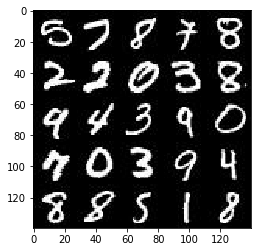

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

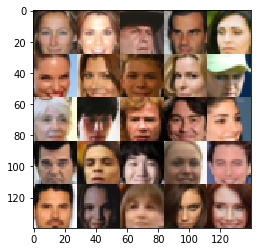

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, [None, image_height, image_width, image_channels], name="input_images")
    z = tf.placeholder(tf.float32, [None, z_dim], name="z")
    learning_rate = tf.placeholder(tf.float32, name="learning_rate")
    

    return input_images, z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [6]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    
    relu_leakage = 0.1
    with tf.variable_scope("discriminator", reuse=reuse):
        # in [batches,28,28,channels] -> convolution [batches,14,14,64] -> batchnorm -> leaky ReLu
        layer = tf.layers.conv2d(images, 64, 5, padding="same", strides=2, activation=None, use_bias=False)
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = tf.maximum(layer * relu_leakage, layer)
        
        # in [batches,14,14,64] -> convolution [batches,7,7,128] -> batchnorm -> leaky ReLu
        layer = tf.layers.conv2d(layer, 128, 5, padding="same", strides=2, activation=None, use_bias=False)
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = tf.maximum(layer * relu_leakage, layer)
        
        # in [batches,7,7,128] -> convolution [batches,3,3,256] -> batchnorm -> leaky ReLu
        layer = tf.layers.conv2d(layer, 256, 3, padding="valid", strides=2, activation=None, use_bias=False)
        layer = tf.layers.batch_normalization(layer, training=True)
        layer = tf.maximum(layer * relu_leakage, layer)
        
        # in [batches,3,3,256] -> flatten [batches,3*3*256]
        flat = tf.contrib.layers.flatten(layer)
        
        # in [batches,3*3*256] -> fully connected [batches,1]        
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [7]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    relu_leakage = 0.1
    with tf.variable_scope("generator", reuse=not is_train):
        # in [batches,z_dim] -> fully connected [batches,7*7*256] -> reshape [batches,7,7,256] -> batchnorm -> leaky ReLu
        layer = tf.layers.dense(z, 7 * 7 * 256)
        layer = tf.reshape(layer, [-1, 7, 7, 256])
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.maximum(layer * relu_leakage, layer)
        
        # in [batches,7,7,256] -> transp conv [batches,14,14,128] -> batchnorm -> leaky ReLu
        layer = tf.layers.conv2d_transpose(layer, 128, 5, strides=2, padding="same")
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.maximum(layer * relu_leakage, layer)
        
        # in [batches,14,14,128] -> transp conv [batches,28,28,64] -> batchnorm -> leaky ReLu
        layer = tf.layers.conv2d_transpose(layer, 64, 5, strides=2, padding="same")
        layer = tf.layers.batch_normalization(layer, training=is_train)
        layer = tf.maximum(layer * relu_leakage, layer)
        
        # in [batches,28,28,64] -> transp conv [batches,28,28,out_channel_dim] -> tanh * 0.5
        images = tf.layers.conv2d_transpose(layer, out_channel_dim, 5, padding="same")
        images = tf.tanh(images) * 0.5
        
    
    return images


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [8]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    # generate fake images
    fake_images = generator(input_z, out_channel_dim)    
    
    # classify real and fake images
    disc_real_out, disc_real_logits = discriminator(input_real)
    disc_fake_out, disc_fake_logits = discriminator(fake_images, reuse=True)
    
    # calc discriminator losses: crossentropy between classification and: real images = 1; fake images = 0
    disc_real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_real_logits, 
                                                                            labels=tf.ones_like(disc_real_logits) * 0.9))
    disc_fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_fake_logits, 
                                                                            labels=tf.zeros_like(disc_fake_logits)))
    # add real and fake discriminator losses
    discriminator_loss = disc_real_loss + disc_fake_loss
    
    # calc generator loss: crossentropy between classification of generated fake images = 1
    generator_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=disc_fake_logits, 
                                                                            labels=tf.ones_like(disc_fake_logits)))
    return discriminator_loss, generator_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [9]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    # actually I would like to try this approach to getting the respective variables; but the unit-test doesn't allow for it
    # d_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="discriminator")
    # g_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, scope="generator")
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train = tf.train.AdamOptimizer(learning_rate, beta1).minimize(d_loss, var_list=d_vars)
        g_train = tf.train.AdamOptimizer(learning_rate, beta1).minimize(g_loss, var_list=g_vars)        
    
    return d_train, g_train


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [10]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [11]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    #image_channels = 3 if data_image_mode == "RGB" else 1
    
    [image_w, image_h, image_channels] = data_shape[1:]
    
    # retrieve input placeholders
    ph_images, ph_z, ph_learning_rate = model_inputs(image_w, image_h, image_channels, z_dim)
    
    # get model losses
    d_loss, g_loss = model_loss(ph_images, ph_z, image_channels)
    
    # setup optimizers
    d_opt, g_opt = model_opt(d_loss, g_loss, ph_learning_rate, beta1)
    
    losses = []
    train_step = 0
    print_step = 10
    show_step = 100
    # sample_generator = generator(ph_z, image_channels, is_train=False)
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                
                train_step = train_step + 1
                #  wrong ->  tf.random_uniform([batch_size, z_dim], -1, 1)
                batch_z = np.random.uniform(-1, 1, (batch_size, z_dim))
                                
                sess.run(d_opt, feed_dict={ph_images: batch_images, 
                                           ph_z: batch_z, 
                                           ph_learning_rate: learning_rate })
                sess.run(g_opt, feed_dict={ph_images: batch_images, 
                                           ph_z: batch_z, 
                                           ph_learning_rate: learning_rate })
                
                if train_step % print_step == 0:
                    (current_d_loss, current_g_loss) = sess.run([d_loss, g_loss],
                                                                feed_dict={ ph_images: batch_images, ph_z: batch_z })     
                    print("Epoch {}/{} - trainstep {}:".format(epoch_i + 1, epoch_count, train_step),
                            "  DiscriminatorLoss: {:.4f}".format(current_d_loss),
                            "  GeneratorLoss    : {:.4f}".format(current_g_loss))
                    
                    losses.append((current_d_loss, current_g_loss))
                    
                if train_step % show_step == 0:
                    # samples = sess.run(sample_generator, feed_dict={ph_z: batch_z})
                    show_generator_output(sess, 16, ph_z, image_channels, data_image_mode)
    return losses

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/5 - trainstep 10:   DiscriminatorLoss: 1.2844   GeneratorLoss    : 1.0811
Epoch 1/5 - trainstep 20:   DiscriminatorLoss: 0.5927   GeneratorLoss    : 2.8206
Epoch 1/5 - trainstep 30:   DiscriminatorLoss: 0.9378   GeneratorLoss    : 1.1900
Epoch 1/5 - trainstep 40:   DiscriminatorLoss: 1.2284   GeneratorLoss    : 1.6105
Epoch 1/5 - trainstep 50:   DiscriminatorLoss: 1.4916   GeneratorLoss    : 0.7425
Epoch 1/5 - trainstep 60:   DiscriminatorLoss: 1.3982   GeneratorLoss    : 1.2241
Epoch 1/5 - trainstep 70:   DiscriminatorLoss: 1.0133   GeneratorLoss    : 1.0807
Epoch 1/5 - trainstep 80:   DiscriminatorLoss: 1.2614   GeneratorLoss    : 0.7676
Epoch 1/5 - trainstep 90:   DiscriminatorLoss: 1.5794   GeneratorLoss    : 2.3103
Epoch 1/5 - trainstep 100:   DiscriminatorLoss: 1.1722   GeneratorLoss    : 0.7420


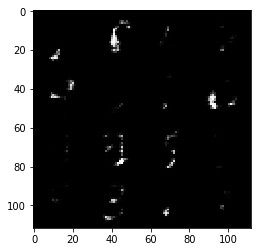

Epoch 1/5 - trainstep 110:   DiscriminatorLoss: 1.2373   GeneratorLoss    : 0.7195
Epoch 1/5 - trainstep 120:   DiscriminatorLoss: 1.0312   GeneratorLoss    : 1.0250
Epoch 1/5 - trainstep 130:   DiscriminatorLoss: 1.3624   GeneratorLoss    : 1.6790
Epoch 1/5 - trainstep 140:   DiscriminatorLoss: 1.4273   GeneratorLoss    : 0.5782
Epoch 1/5 - trainstep 150:   DiscriminatorLoss: 1.2259   GeneratorLoss    : 0.9771
Epoch 1/5 - trainstep 160:   DiscriminatorLoss: 1.2940   GeneratorLoss    : 0.7522
Epoch 1/5 - trainstep 170:   DiscriminatorLoss: 1.5566   GeneratorLoss    : 0.4734
Epoch 1/5 - trainstep 180:   DiscriminatorLoss: 1.5611   GeneratorLoss    : 0.4472
Epoch 1/5 - trainstep 190:   DiscriminatorLoss: 1.2010   GeneratorLoss    : 0.8912
Epoch 1/5 - trainstep 200:   DiscriminatorLoss: 1.2479   GeneratorLoss    : 1.3203


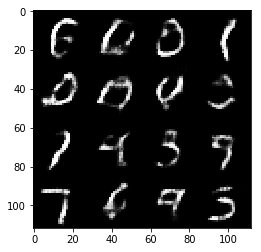

Epoch 1/5 - trainstep 210:   DiscriminatorLoss: 1.2757   GeneratorLoss    : 0.7850
Epoch 1/5 - trainstep 220:   DiscriminatorLoss: 1.2573   GeneratorLoss    : 1.0725
Epoch 1/5 - trainstep 230:   DiscriminatorLoss: 1.1755   GeneratorLoss    : 1.2945
Epoch 1/5 - trainstep 240:   DiscriminatorLoss: 1.1736   GeneratorLoss    : 0.8517
Epoch 1/5 - trainstep 250:   DiscriminatorLoss: 1.4670   GeneratorLoss    : 0.4936
Epoch 1/5 - trainstep 260:   DiscriminatorLoss: 1.1940   GeneratorLoss    : 0.8071
Epoch 1/5 - trainstep 270:   DiscriminatorLoss: 1.1957   GeneratorLoss    : 0.8251
Epoch 1/5 - trainstep 280:   DiscriminatorLoss: 1.2526   GeneratorLoss    : 0.6791
Epoch 1/5 - trainstep 290:   DiscriminatorLoss: 1.2902   GeneratorLoss    : 0.6115
Epoch 1/5 - trainstep 300:   DiscriminatorLoss: 1.1705   GeneratorLoss    : 1.1922


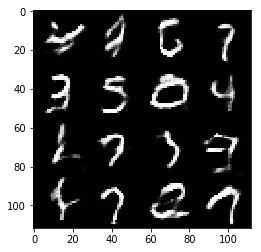

Epoch 1/5 - trainstep 310:   DiscriminatorLoss: 1.1330   GeneratorLoss    : 0.9828
Epoch 1/5 - trainstep 320:   DiscriminatorLoss: 1.6570   GeneratorLoss    : 2.4270
Epoch 1/5 - trainstep 330:   DiscriminatorLoss: 1.4380   GeneratorLoss    : 0.5735
Epoch 1/5 - trainstep 340:   DiscriminatorLoss: 1.2446   GeneratorLoss    : 1.2283
Epoch 1/5 - trainstep 350:   DiscriminatorLoss: 1.1507   GeneratorLoss    : 1.1569
Epoch 1/5 - trainstep 360:   DiscriminatorLoss: 1.3181   GeneratorLoss    : 1.9110
Epoch 1/5 - trainstep 370:   DiscriminatorLoss: 1.1750   GeneratorLoss    : 1.2684
Epoch 1/5 - trainstep 380:   DiscriminatorLoss: 1.3111   GeneratorLoss    : 0.6427
Epoch 1/5 - trainstep 390:   DiscriminatorLoss: 1.3099   GeneratorLoss    : 0.6735
Epoch 1/5 - trainstep 400:   DiscriminatorLoss: 1.1455   GeneratorLoss    : 0.8920


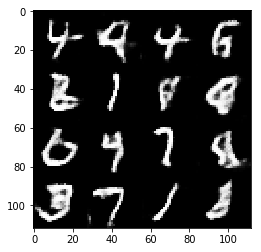

Epoch 1/5 - trainstep 410:   DiscriminatorLoss: 1.3368   GeneratorLoss    : 0.6873
Epoch 1/5 - trainstep 420:   DiscriminatorLoss: 1.0751   GeneratorLoss    : 1.4337
Epoch 1/5 - trainstep 430:   DiscriminatorLoss: 1.3787   GeneratorLoss    : 0.5606
Epoch 1/5 - trainstep 440:   DiscriminatorLoss: 1.2949   GeneratorLoss    : 0.5830
Epoch 1/5 - trainstep 450:   DiscriminatorLoss: 1.1444   GeneratorLoss    : 0.8204
Epoch 1/5 - trainstep 460:   DiscriminatorLoss: 1.6216   GeneratorLoss    : 0.3900
Epoch 2/5 - trainstep 470:   DiscriminatorLoss: 1.3322   GeneratorLoss    : 1.0941
Epoch 2/5 - trainstep 480:   DiscriminatorLoss: 1.2113   GeneratorLoss    : 1.2539
Epoch 2/5 - trainstep 490:   DiscriminatorLoss: 1.2345   GeneratorLoss    : 0.7432
Epoch 2/5 - trainstep 500:   DiscriminatorLoss: 1.2129   GeneratorLoss    : 1.5324


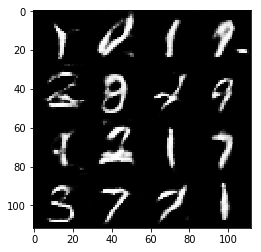

Epoch 2/5 - trainstep 510:   DiscriminatorLoss: 1.2314   GeneratorLoss    : 0.6885
Epoch 2/5 - trainstep 520:   DiscriminatorLoss: 1.7373   GeneratorLoss    : 0.3593
Epoch 2/5 - trainstep 530:   DiscriminatorLoss: 1.1104   GeneratorLoss    : 0.9291
Epoch 2/5 - trainstep 540:   DiscriminatorLoss: 1.2605   GeneratorLoss    : 0.6552
Epoch 2/5 - trainstep 550:   DiscriminatorLoss: 1.1630   GeneratorLoss    : 1.7302
Epoch 2/5 - trainstep 560:   DiscriminatorLoss: 1.1668   GeneratorLoss    : 1.8141
Epoch 2/5 - trainstep 570:   DiscriminatorLoss: 1.3152   GeneratorLoss    : 0.6155
Epoch 2/5 - trainstep 580:   DiscriminatorLoss: 1.0905   GeneratorLoss    : 1.0981
Epoch 2/5 - trainstep 590:   DiscriminatorLoss: 1.0947   GeneratorLoss    : 1.6186
Epoch 2/5 - trainstep 600:   DiscriminatorLoss: 1.2100   GeneratorLoss    : 1.7389


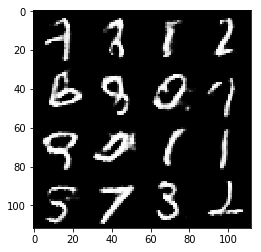

Epoch 2/5 - trainstep 610:   DiscriminatorLoss: 1.1816   GeneratorLoss    : 0.7362
Epoch 2/5 - trainstep 620:   DiscriminatorLoss: 1.1896   GeneratorLoss    : 0.8527
Epoch 2/5 - trainstep 630:   DiscriminatorLoss: 1.5218   GeneratorLoss    : 0.4654
Epoch 2/5 - trainstep 640:   DiscriminatorLoss: 1.1804   GeneratorLoss    : 0.8654
Epoch 2/5 - trainstep 650:   DiscriminatorLoss: 1.5714   GeneratorLoss    : 0.4631
Epoch 2/5 - trainstep 660:   DiscriminatorLoss: 1.6135   GeneratorLoss    : 0.4606
Epoch 2/5 - trainstep 670:   DiscriminatorLoss: 1.0627   GeneratorLoss    : 1.0683
Epoch 2/5 - trainstep 680:   DiscriminatorLoss: 1.0571   GeneratorLoss    : 0.8958
Epoch 2/5 - trainstep 690:   DiscriminatorLoss: 1.8204   GeneratorLoss    : 0.3464
Epoch 2/5 - trainstep 700:   DiscriminatorLoss: 0.9736   GeneratorLoss    : 1.1527


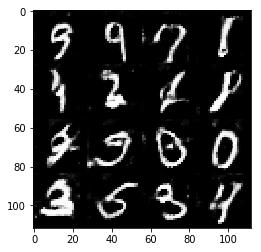

Epoch 2/5 - trainstep 710:   DiscriminatorLoss: 1.0654   GeneratorLoss    : 2.1267
Epoch 2/5 - trainstep 720:   DiscriminatorLoss: 1.1985   GeneratorLoss    : 0.6911
Epoch 2/5 - trainstep 730:   DiscriminatorLoss: 1.9707   GeneratorLoss    : 3.0102
Epoch 2/5 - trainstep 740:   DiscriminatorLoss: 1.3411   GeneratorLoss    : 0.6169
Epoch 2/5 - trainstep 750:   DiscriminatorLoss: 1.1197   GeneratorLoss    : 1.1835
Epoch 2/5 - trainstep 760:   DiscriminatorLoss: 1.0806   GeneratorLoss    : 1.4200
Epoch 2/5 - trainstep 770:   DiscriminatorLoss: 0.9192   GeneratorLoss    : 1.1048
Epoch 2/5 - trainstep 780:   DiscriminatorLoss: 1.1214   GeneratorLoss    : 0.9086
Epoch 2/5 - trainstep 790:   DiscriminatorLoss: 1.0581   GeneratorLoss    : 1.6739
Epoch 2/5 - trainstep 800:   DiscriminatorLoss: 1.1728   GeneratorLoss    : 0.8737


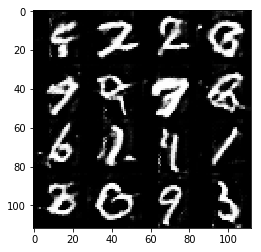

Epoch 2/5 - trainstep 810:   DiscriminatorLoss: 1.1440   GeneratorLoss    : 1.6761
Epoch 2/5 - trainstep 820:   DiscriminatorLoss: 1.1082   GeneratorLoss    : 1.9680
Epoch 2/5 - trainstep 830:   DiscriminatorLoss: 1.0996   GeneratorLoss    : 1.0161
Epoch 2/5 - trainstep 840:   DiscriminatorLoss: 0.8081   GeneratorLoss    : 1.6056
Epoch 2/5 - trainstep 850:   DiscriminatorLoss: 1.7424   GeneratorLoss    : 3.0204
Epoch 2/5 - trainstep 860:   DiscriminatorLoss: 1.3056   GeneratorLoss    : 0.6610
Epoch 2/5 - trainstep 870:   DiscriminatorLoss: 1.1170   GeneratorLoss    : 0.9574
Epoch 2/5 - trainstep 880:   DiscriminatorLoss: 1.2192   GeneratorLoss    : 0.8929
Epoch 2/5 - trainstep 890:   DiscriminatorLoss: 1.7382   GeneratorLoss    : 2.1214
Epoch 2/5 - trainstep 900:   DiscriminatorLoss: 1.1432   GeneratorLoss    : 0.7958


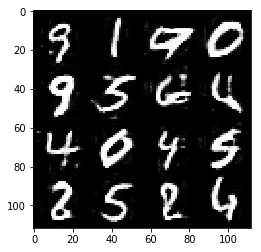

Epoch 2/5 - trainstep 910:   DiscriminatorLoss: 1.2124   GeneratorLoss    : 0.6451
Epoch 2/5 - trainstep 920:   DiscriminatorLoss: 1.7868   GeneratorLoss    : 1.9098
Epoch 2/5 - trainstep 930:   DiscriminatorLoss: 1.1485   GeneratorLoss    : 0.8928
Epoch 3/5 - trainstep 940:   DiscriminatorLoss: 1.0602   GeneratorLoss    : 1.0734
Epoch 3/5 - trainstep 950:   DiscriminatorLoss: 0.8025   GeneratorLoss    : 1.3007
Epoch 3/5 - trainstep 960:   DiscriminatorLoss: 1.1823   GeneratorLoss    : 0.8821
Epoch 3/5 - trainstep 970:   DiscriminatorLoss: 1.2080   GeneratorLoss    : 0.8104
Epoch 3/5 - trainstep 980:   DiscriminatorLoss: 1.1285   GeneratorLoss    : 0.8113
Epoch 3/5 - trainstep 990:   DiscriminatorLoss: 0.9249   GeneratorLoss    : 1.5504
Epoch 3/5 - trainstep 1000:   DiscriminatorLoss: 1.5460   GeneratorLoss    : 0.4880


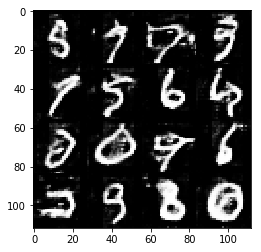

Epoch 3/5 - trainstep 1010:   DiscriminatorLoss: 1.0977   GeneratorLoss    : 0.9201
Epoch 3/5 - trainstep 1020:   DiscriminatorLoss: 0.8755   GeneratorLoss    : 1.2702
Epoch 3/5 - trainstep 1030:   DiscriminatorLoss: 0.8671   GeneratorLoss    : 1.0431
Epoch 3/5 - trainstep 1040:   DiscriminatorLoss: 1.2469   GeneratorLoss    : 1.4365
Epoch 3/5 - trainstep 1050:   DiscriminatorLoss: 1.0288   GeneratorLoss    : 1.1264
Epoch 3/5 - trainstep 1060:   DiscriminatorLoss: 1.0495   GeneratorLoss    : 1.0030
Epoch 3/5 - trainstep 1070:   DiscriminatorLoss: 2.2304   GeneratorLoss    : 4.0459
Epoch 3/5 - trainstep 1080:   DiscriminatorLoss: 1.2567   GeneratorLoss    : 0.7038
Epoch 3/5 - trainstep 1090:   DiscriminatorLoss: 1.1343   GeneratorLoss    : 0.9629
Epoch 3/5 - trainstep 1100:   DiscriminatorLoss: 1.1001   GeneratorLoss    : 0.9779


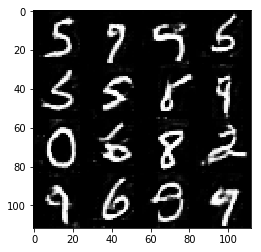

Epoch 3/5 - trainstep 1110:   DiscriminatorLoss: 1.0759   GeneratorLoss    : 1.2224
Epoch 3/5 - trainstep 1120:   DiscriminatorLoss: 1.0212   GeneratorLoss    : 1.6096
Epoch 3/5 - trainstep 1130:   DiscriminatorLoss: 0.9638   GeneratorLoss    : 1.0344
Epoch 3/5 - trainstep 1140:   DiscriminatorLoss: 1.1843   GeneratorLoss    : 1.6317
Epoch 3/5 - trainstep 1150:   DiscriminatorLoss: 1.0598   GeneratorLoss    : 0.9825
Epoch 3/5 - trainstep 1160:   DiscriminatorLoss: 0.9142   GeneratorLoss    : 1.1066
Epoch 3/5 - trainstep 1170:   DiscriminatorLoss: 1.3185   GeneratorLoss    : 0.6155
Epoch 3/5 - trainstep 1180:   DiscriminatorLoss: 1.0340   GeneratorLoss    : 0.9789
Epoch 3/5 - trainstep 1190:   DiscriminatorLoss: 0.9628   GeneratorLoss    : 1.2739
Epoch 3/5 - trainstep 1200:   DiscriminatorLoss: 0.8802   GeneratorLoss    : 1.1618


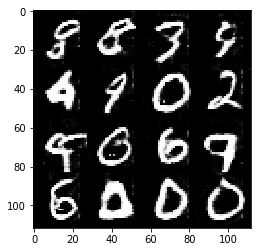

Epoch 3/5 - trainstep 1210:   DiscriminatorLoss: 1.4749   GeneratorLoss    : 0.5512
Epoch 3/5 - trainstep 1220:   DiscriminatorLoss: 0.9815   GeneratorLoss    : 0.9090
Epoch 3/5 - trainstep 1230:   DiscriminatorLoss: 1.5244   GeneratorLoss    : 0.4446
Epoch 3/5 - trainstep 1240:   DiscriminatorLoss: 1.0629   GeneratorLoss    : 0.9990
Epoch 3/5 - trainstep 1250:   DiscriminatorLoss: 0.9333   GeneratorLoss    : 1.2533
Epoch 3/5 - trainstep 1260:   DiscriminatorLoss: 0.7508   GeneratorLoss    : 1.4662
Epoch 3/5 - trainstep 1270:   DiscriminatorLoss: 1.2956   GeneratorLoss    : 0.8165
Epoch 3/5 - trainstep 1280:   DiscriminatorLoss: 0.7884   GeneratorLoss    : 1.5624
Epoch 3/5 - trainstep 1290:   DiscriminatorLoss: 0.8656   GeneratorLoss    : 1.1339
Epoch 3/5 - trainstep 1300:   DiscriminatorLoss: 1.3228   GeneratorLoss    : 1.0110


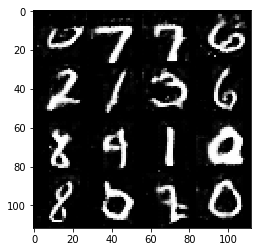

Epoch 3/5 - trainstep 1310:   DiscriminatorLoss: 1.0105   GeneratorLoss    : 1.0463
Epoch 3/5 - trainstep 1320:   DiscriminatorLoss: 0.8066   GeneratorLoss    : 1.2531
Epoch 3/5 - trainstep 1330:   DiscriminatorLoss: 0.5805   GeneratorLoss    : 2.4854
Epoch 3/5 - trainstep 1340:   DiscriminatorLoss: 1.3284   GeneratorLoss    : 0.6200
Epoch 3/5 - trainstep 1350:   DiscriminatorLoss: 0.9426   GeneratorLoss    : 1.4431
Epoch 3/5 - trainstep 1360:   DiscriminatorLoss: 0.9173   GeneratorLoss    : 1.1947
Epoch 3/5 - trainstep 1370:   DiscriminatorLoss: 0.9238   GeneratorLoss    : 2.3548
Epoch 3/5 - trainstep 1380:   DiscriminatorLoss: 0.9823   GeneratorLoss    : 1.1775
Epoch 3/5 - trainstep 1390:   DiscriminatorLoss: 1.0250   GeneratorLoss    : 0.9302
Epoch 3/5 - trainstep 1400:   DiscriminatorLoss: 1.2328   GeneratorLoss    : 0.6675


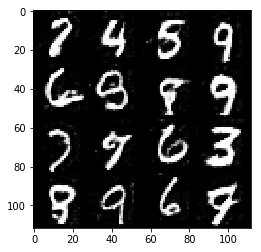

Epoch 4/5 - trainstep 1410:   DiscriminatorLoss: 1.1354   GeneratorLoss    : 1.2734
Epoch 4/5 - trainstep 1420:   DiscriminatorLoss: 0.7424   GeneratorLoss    : 1.3468
Epoch 4/5 - trainstep 1430:   DiscriminatorLoss: 1.1569   GeneratorLoss    : 1.8325
Epoch 4/5 - trainstep 1440:   DiscriminatorLoss: 1.2189   GeneratorLoss    : 0.7244
Epoch 4/5 - trainstep 1450:   DiscriminatorLoss: 1.0806   GeneratorLoss    : 0.8198
Epoch 4/5 - trainstep 1460:   DiscriminatorLoss: 1.0857   GeneratorLoss    : 1.3648
Epoch 4/5 - trainstep 1470:   DiscriminatorLoss: 1.3549   GeneratorLoss    : 0.6158
Epoch 4/5 - trainstep 1480:   DiscriminatorLoss: 1.0380   GeneratorLoss    : 1.1477
Epoch 4/5 - trainstep 1490:   DiscriminatorLoss: 0.9678   GeneratorLoss    : 1.1826
Epoch 4/5 - trainstep 1500:   DiscriminatorLoss: 0.9911   GeneratorLoss    : 0.9304


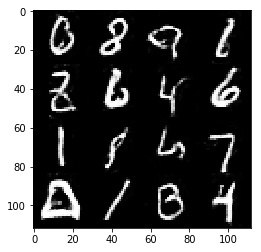

Epoch 4/5 - trainstep 1510:   DiscriminatorLoss: 2.0134   GeneratorLoss    : 0.2750
Epoch 4/5 - trainstep 1520:   DiscriminatorLoss: 1.2402   GeneratorLoss    : 0.7301
Epoch 4/5 - trainstep 1530:   DiscriminatorLoss: 1.3501   GeneratorLoss    : 0.5973
Epoch 4/5 - trainstep 1540:   DiscriminatorLoss: 2.1115   GeneratorLoss    : 0.2967
Epoch 4/5 - trainstep 1550:   DiscriminatorLoss: 1.2015   GeneratorLoss    : 0.6956
Epoch 4/5 - trainstep 1560:   DiscriminatorLoss: 1.0312   GeneratorLoss    : 1.5102
Epoch 4/5 - trainstep 1570:   DiscriminatorLoss: 1.0405   GeneratorLoss    : 1.1963
Epoch 4/5 - trainstep 1580:   DiscriminatorLoss: 1.3706   GeneratorLoss    : 0.6558
Epoch 4/5 - trainstep 1590:   DiscriminatorLoss: 1.1115   GeneratorLoss    : 0.8144
Epoch 4/5 - trainstep 1600:   DiscriminatorLoss: 1.0371   GeneratorLoss    : 1.2036


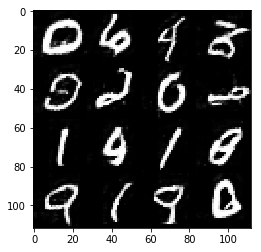

Epoch 4/5 - trainstep 1610:   DiscriminatorLoss: 0.9041   GeneratorLoss    : 1.0852
Epoch 4/5 - trainstep 1620:   DiscriminatorLoss: 0.8995   GeneratorLoss    : 1.2276
Epoch 4/5 - trainstep 1630:   DiscriminatorLoss: 3.0168   GeneratorLoss    : 0.1405
Epoch 4/5 - trainstep 1640:   DiscriminatorLoss: 1.0628   GeneratorLoss    : 0.9431
Epoch 4/5 - trainstep 1650:   DiscriminatorLoss: 1.0709   GeneratorLoss    : 0.8537
Epoch 4/5 - trainstep 1660:   DiscriminatorLoss: 0.8137   GeneratorLoss    : 1.4105
Epoch 4/5 - trainstep 1670:   DiscriminatorLoss: 0.9693   GeneratorLoss    : 0.9937
Epoch 4/5 - trainstep 1680:   DiscriminatorLoss: 0.9827   GeneratorLoss    : 1.0398
Epoch 4/5 - trainstep 1690:   DiscriminatorLoss: 0.7725   GeneratorLoss    : 1.9045
Epoch 4/5 - trainstep 1700:   DiscriminatorLoss: 1.4389   GeneratorLoss    : 0.5499


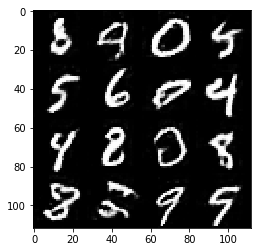

Epoch 4/5 - trainstep 1710:   DiscriminatorLoss: 0.9838   GeneratorLoss    : 1.1373
Epoch 4/5 - trainstep 1720:   DiscriminatorLoss: 1.1491   GeneratorLoss    : 0.8128
Epoch 4/5 - trainstep 1730:   DiscriminatorLoss: 1.2772   GeneratorLoss    : 0.6710
Epoch 4/5 - trainstep 1740:   DiscriminatorLoss: 0.7758   GeneratorLoss    : 1.3624
Epoch 4/5 - trainstep 1750:   DiscriminatorLoss: 0.7829   GeneratorLoss    : 1.3669
Epoch 4/5 - trainstep 1760:   DiscriminatorLoss: 1.0734   GeneratorLoss    : 2.1692
Epoch 4/5 - trainstep 1770:   DiscriminatorLoss: 1.3040   GeneratorLoss    : 1.7111
Epoch 4/5 - trainstep 1780:   DiscriminatorLoss: 1.2725   GeneratorLoss    : 0.6542
Epoch 4/5 - trainstep 1790:   DiscriminatorLoss: 1.6352   GeneratorLoss    : 2.7295
Epoch 4/5 - trainstep 1800:   DiscriminatorLoss: 2.6520   GeneratorLoss    : 0.1734


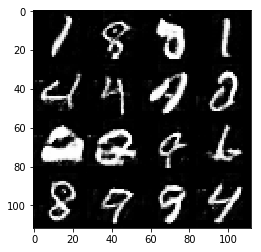

Epoch 4/5 - trainstep 1810:   DiscriminatorLoss: 0.9474   GeneratorLoss    : 1.2699
Epoch 4/5 - trainstep 1820:   DiscriminatorLoss: 0.9663   GeneratorLoss    : 1.0189
Epoch 4/5 - trainstep 1830:   DiscriminatorLoss: 1.7563   GeneratorLoss    : 2.6043
Epoch 4/5 - trainstep 1840:   DiscriminatorLoss: 1.5130   GeneratorLoss    : 0.4761
Epoch 4/5 - trainstep 1850:   DiscriminatorLoss: 1.1527   GeneratorLoss    : 1.7858
Epoch 4/5 - trainstep 1860:   DiscriminatorLoss: 1.6221   GeneratorLoss    : 0.4461
Epoch 4/5 - trainstep 1870:   DiscriminatorLoss: 1.9834   GeneratorLoss    : 0.2871
Epoch 5/5 - trainstep 1880:   DiscriminatorLoss: 1.1494   GeneratorLoss    : 0.8087
Epoch 5/5 - trainstep 1890:   DiscriminatorLoss: 1.0289   GeneratorLoss    : 0.9586
Epoch 5/5 - trainstep 1900:   DiscriminatorLoss: 1.0277   GeneratorLoss    : 1.6002


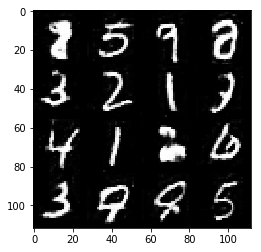

Epoch 5/5 - trainstep 1910:   DiscriminatorLoss: 1.2178   GeneratorLoss    : 0.8593
Epoch 5/5 - trainstep 1920:   DiscriminatorLoss: 0.9444   GeneratorLoss    : 1.3928
Epoch 5/5 - trainstep 1930:   DiscriminatorLoss: 1.3276   GeneratorLoss    : 2.6957
Epoch 5/5 - trainstep 1940:   DiscriminatorLoss: 1.0923   GeneratorLoss    : 1.1761
Epoch 5/5 - trainstep 1950:   DiscriminatorLoss: 1.1551   GeneratorLoss    : 0.8050
Epoch 5/5 - trainstep 1960:   DiscriminatorLoss: 0.7659   GeneratorLoss    : 1.4082
Epoch 5/5 - trainstep 1970:   DiscriminatorLoss: 1.3406   GeneratorLoss    : 2.0009
Epoch 5/5 - trainstep 1980:   DiscriminatorLoss: 1.0751   GeneratorLoss    : 1.1082
Epoch 5/5 - trainstep 1990:   DiscriminatorLoss: 1.1339   GeneratorLoss    : 0.8149
Epoch 5/5 - trainstep 2000:   DiscriminatorLoss: 0.7963   GeneratorLoss    : 1.9042


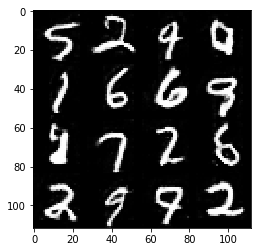

Epoch 5/5 - trainstep 2010:   DiscriminatorLoss: 1.1833   GeneratorLoss    : 1.0262
Epoch 5/5 - trainstep 2020:   DiscriminatorLoss: 1.4370   GeneratorLoss    : 2.9489
Epoch 5/5 - trainstep 2030:   DiscriminatorLoss: 0.9536   GeneratorLoss    : 1.0527
Epoch 5/5 - trainstep 2040:   DiscriminatorLoss: 1.0074   GeneratorLoss    : 1.0991
Epoch 5/5 - trainstep 2050:   DiscriminatorLoss: 1.1251   GeneratorLoss    : 1.0463
Epoch 5/5 - trainstep 2060:   DiscriminatorLoss: 1.2512   GeneratorLoss    : 0.6772
Epoch 5/5 - trainstep 2070:   DiscriminatorLoss: 0.7511   GeneratorLoss    : 1.5007
Epoch 5/5 - trainstep 2080:   DiscriminatorLoss: 1.1335   GeneratorLoss    : 1.0401
Epoch 5/5 - trainstep 2090:   DiscriminatorLoss: 1.2468   GeneratorLoss    : 0.9334
Epoch 5/5 - trainstep 2100:   DiscriminatorLoss: 1.1278   GeneratorLoss    : 0.8509


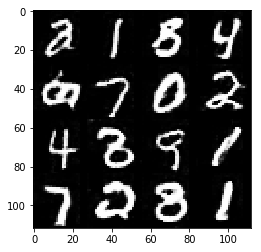

Epoch 5/5 - trainstep 2110:   DiscriminatorLoss: 0.9496   GeneratorLoss    : 1.1516
Epoch 5/5 - trainstep 2120:   DiscriminatorLoss: 1.2335   GeneratorLoss    : 0.6824
Epoch 5/5 - trainstep 2130:   DiscriminatorLoss: 0.9087   GeneratorLoss    : 1.2379
Epoch 5/5 - trainstep 2140:   DiscriminatorLoss: 0.8704   GeneratorLoss    : 1.3965
Epoch 5/5 - trainstep 2150:   DiscriminatorLoss: 0.7809   GeneratorLoss    : 1.3827
Epoch 5/5 - trainstep 2160:   DiscriminatorLoss: 1.4492   GeneratorLoss    : 2.4107
Epoch 5/5 - trainstep 2170:   DiscriminatorLoss: 1.6408   GeneratorLoss    : 0.4679
Epoch 5/5 - trainstep 2180:   DiscriminatorLoss: 1.0533   GeneratorLoss    : 1.3739
Epoch 5/5 - trainstep 2190:   DiscriminatorLoss: 0.7597   GeneratorLoss    : 1.6189
Epoch 5/5 - trainstep 2200:   DiscriminatorLoss: 1.4614   GeneratorLoss    : 0.5455


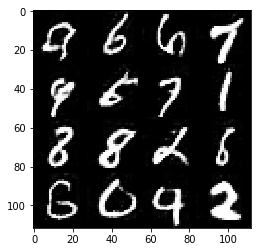

Epoch 5/5 - trainstep 2210:   DiscriminatorLoss: 1.0126   GeneratorLoss    : 1.3492
Epoch 5/5 - trainstep 2220:   DiscriminatorLoss: 1.2913   GeneratorLoss    : 0.7160
Epoch 5/5 - trainstep 2230:   DiscriminatorLoss: 0.9774   GeneratorLoss    : 1.0373
Epoch 5/5 - trainstep 2240:   DiscriminatorLoss: 1.6450   GeneratorLoss    : 0.4857
Epoch 5/5 - trainstep 2250:   DiscriminatorLoss: 1.0220   GeneratorLoss    : 1.2303
Epoch 5/5 - trainstep 2260:   DiscriminatorLoss: 1.4087   GeneratorLoss    : 0.5586
Epoch 5/5 - trainstep 2270:   DiscriminatorLoss: 1.3870   GeneratorLoss    : 0.6161
Epoch 5/5 - trainstep 2280:   DiscriminatorLoss: 1.2849   GeneratorLoss    : 1.2183
Epoch 5/5 - trainstep 2290:   DiscriminatorLoss: 1.3109   GeneratorLoss    : 0.6984
Epoch 5/5 - trainstep 2300:   DiscriminatorLoss: 1.1682   GeneratorLoss    : 0.8176


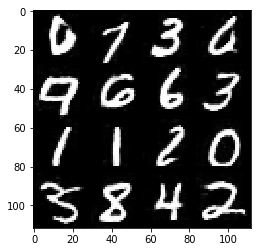

Epoch 5/5 - trainstep 2310:   DiscriminatorLoss: 0.9493   GeneratorLoss    : 1.1911


In [ ]:
batch_size = 128
z_dim = 128
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 5

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/2 - trainstep 10:   DiscriminatorLoss: 0.3733   GeneratorLoss    : 10.0980
Epoch 1/2 - trainstep 20:   DiscriminatorLoss: 0.6926   GeneratorLoss    : 1.9395
Epoch 1/2 - trainstep 30:   DiscriminatorLoss: 0.7659   GeneratorLoss    : 1.5511
Epoch 1/2 - trainstep 40:   DiscriminatorLoss: 0.7361   GeneratorLoss    : 2.5761
Epoch 1/2 - trainstep 50:   DiscriminatorLoss: 0.8226   GeneratorLoss    : 1.6412
Epoch 1/2 - trainstep 60:   DiscriminatorLoss: 2.0388   GeneratorLoss    : 5.0177
Epoch 1/2 - trainstep 70:   DiscriminatorLoss: 1.1801   GeneratorLoss    : 4.5264
Epoch 1/2 - trainstep 80:   DiscriminatorLoss: 1.0776   GeneratorLoss    : 1.3531
Epoch 1/2 - trainstep 90:   DiscriminatorLoss: 1.2890   GeneratorLoss    : 0.8020
Epoch 1/2 - trainstep 100:   DiscriminatorLoss: 1.3428   GeneratorLoss    : 0.9473


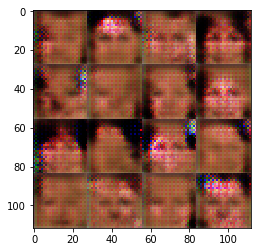

Epoch 1/2 - trainstep 110:   DiscriminatorLoss: 1.6026   GeneratorLoss    : 0.4486
Epoch 1/2 - trainstep 120:   DiscriminatorLoss: 1.8581   GeneratorLoss    : 0.3327
Epoch 1/2 - trainstep 130:   DiscriminatorLoss: 1.2748   GeneratorLoss    : 0.7310
Epoch 1/2 - trainstep 140:   DiscriminatorLoss: 1.2572   GeneratorLoss    : 1.4654
Epoch 1/2 - trainstep 150:   DiscriminatorLoss: 1.8337   GeneratorLoss    : 2.2561
Epoch 1/2 - trainstep 160:   DiscriminatorLoss: 1.2225   GeneratorLoss    : 0.7108
Epoch 1/2 - trainstep 170:   DiscriminatorLoss: 1.2394   GeneratorLoss    : 0.6752
Epoch 1/2 - trainstep 180:   DiscriminatorLoss: 2.0895   GeneratorLoss    : 2.9437
Epoch 1/2 - trainstep 190:   DiscriminatorLoss: 1.5110   GeneratorLoss    : 0.6370
Epoch 1/2 - trainstep 200:   DiscriminatorLoss: 1.3768   GeneratorLoss    : 0.9781


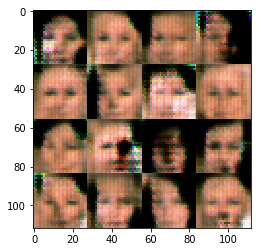

Epoch 1/2 - trainstep 210:   DiscriminatorLoss: 1.2386   GeneratorLoss    : 0.7018
Epoch 1/2 - trainstep 220:   DiscriminatorLoss: 1.3786   GeneratorLoss    : 0.6083
Epoch 1/2 - trainstep 230:   DiscriminatorLoss: 1.7746   GeneratorLoss    : 1.6426
Epoch 1/2 - trainstep 240:   DiscriminatorLoss: 1.2172   GeneratorLoss    : 0.8978
Epoch 1/2 - trainstep 250:   DiscriminatorLoss: 1.7228   GeneratorLoss    : 0.4559
Epoch 1/2 - trainstep 260:   DiscriminatorLoss: 1.7122   GeneratorLoss    : 0.3979
Epoch 1/2 - trainstep 270:   DiscriminatorLoss: 1.1653   GeneratorLoss    : 0.8650
Epoch 1/2 - trainstep 280:   DiscriminatorLoss: 1.3857   GeneratorLoss    : 0.9055
Epoch 1/2 - trainstep 290:   DiscriminatorLoss: 1.4949   GeneratorLoss    : 0.4621
Epoch 1/2 - trainstep 300:   DiscriminatorLoss: 1.4983   GeneratorLoss    : 0.5752


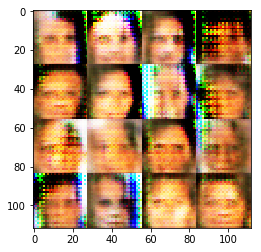

Epoch 1/2 - trainstep 310:   DiscriminatorLoss: 1.5058   GeneratorLoss    : 1.3168
Epoch 1/2 - trainstep 320:   DiscriminatorLoss: 1.1400   GeneratorLoss    : 0.8337
Epoch 1/2 - trainstep 330:   DiscriminatorLoss: 1.3491   GeneratorLoss    : 0.6936
Epoch 1/2 - trainstep 340:   DiscriminatorLoss: 1.4725   GeneratorLoss    : 1.4718
Epoch 1/2 - trainstep 350:   DiscriminatorLoss: 1.1177   GeneratorLoss    : 1.0341
Epoch 1/2 - trainstep 360:   DiscriminatorLoss: 1.7833   GeneratorLoss    : 2.1149
Epoch 1/2 - trainstep 370:   DiscriminatorLoss: 1.3358   GeneratorLoss    : 0.6549
Epoch 1/2 - trainstep 380:   DiscriminatorLoss: 1.5550   GeneratorLoss    : 0.4765
Epoch 1/2 - trainstep 390:   DiscriminatorLoss: 1.4329   GeneratorLoss    : 0.6254
Epoch 1/2 - trainstep 400:   DiscriminatorLoss: 1.2403   GeneratorLoss    : 0.9912


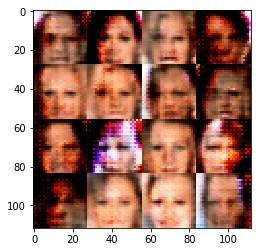

Epoch 1/2 - trainstep 410:   DiscriminatorLoss: 1.5498   GeneratorLoss    : 1.5269
Epoch 1/2 - trainstep 420:   DiscriminatorLoss: 1.4472   GeneratorLoss    : 0.5824
Epoch 1/2 - trainstep 430:   DiscriminatorLoss: 1.2749   GeneratorLoss    : 0.9731
Epoch 1/2 - trainstep 440:   DiscriminatorLoss: 1.3567   GeneratorLoss    : 1.0352
Epoch 1/2 - trainstep 450:   DiscriminatorLoss: 1.3375   GeneratorLoss    : 0.8707
Epoch 1/2 - trainstep 460:   DiscriminatorLoss: 1.4410   GeneratorLoss    : 0.6518
Epoch 1/2 - trainstep 470:   DiscriminatorLoss: 1.2994   GeneratorLoss    : 0.8330
Epoch 1/2 - trainstep 480:   DiscriminatorLoss: 1.2575   GeneratorLoss    : 0.8094
Epoch 1/2 - trainstep 490:   DiscriminatorLoss: 1.1059   GeneratorLoss    : 0.9836
Epoch 1/2 - trainstep 500:   DiscriminatorLoss: 1.9327   GeneratorLoss    : 0.2766


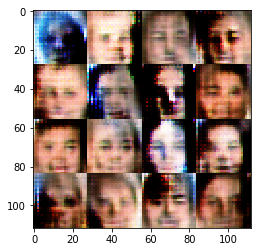

Epoch 1/2 - trainstep 510:   DiscriminatorLoss: 1.4055   GeneratorLoss    : 1.1086
Epoch 1/2 - trainstep 520:   DiscriminatorLoss: 1.3900   GeneratorLoss    : 0.6998
Epoch 1/2 - trainstep 530:   DiscriminatorLoss: 1.3069   GeneratorLoss    : 1.2180
Epoch 1/2 - trainstep 540:   DiscriminatorLoss: 1.3456   GeneratorLoss    : 0.7289
Epoch 1/2 - trainstep 550:   DiscriminatorLoss: 1.2675   GeneratorLoss    : 0.9853
Epoch 1/2 - trainstep 560:   DiscriminatorLoss: 1.3660   GeneratorLoss    : 1.2676
Epoch 1/2 - trainstep 570:   DiscriminatorLoss: 1.3249   GeneratorLoss    : 0.8109
Epoch 1/2 - trainstep 580:   DiscriminatorLoss: 1.3012   GeneratorLoss    : 0.6131
Epoch 1/2 - trainstep 590:   DiscriminatorLoss: 1.3453   GeneratorLoss    : 0.6447
Epoch 1/2 - trainstep 600:   DiscriminatorLoss: 1.5494   GeneratorLoss    : 0.6241


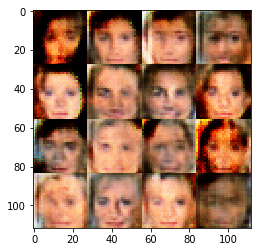

Epoch 1/2 - trainstep 610:   DiscriminatorLoss: 1.3819   GeneratorLoss    : 0.8509
Epoch 1/2 - trainstep 620:   DiscriminatorLoss: 1.3300   GeneratorLoss    : 0.6205
Epoch 1/2 - trainstep 630:   DiscriminatorLoss: 1.4237   GeneratorLoss    : 1.1538
Epoch 1/2 - trainstep 640:   DiscriminatorLoss: 1.4060   GeneratorLoss    : 0.5833
Epoch 1/2 - trainstep 650:   DiscriminatorLoss: 1.4181   GeneratorLoss    : 0.5434
Epoch 1/2 - trainstep 660:   DiscriminatorLoss: 1.4109   GeneratorLoss    : 0.8511
Epoch 1/2 - trainstep 670:   DiscriminatorLoss: 1.3373   GeneratorLoss    : 0.6558
Epoch 1/2 - trainstep 680:   DiscriminatorLoss: 1.4179   GeneratorLoss    : 0.5765
Epoch 1/2 - trainstep 690:   DiscriminatorLoss: 1.4735   GeneratorLoss    : 0.6537
Epoch 1/2 - trainstep 700:   DiscriminatorLoss: 1.3364   GeneratorLoss    : 0.8196


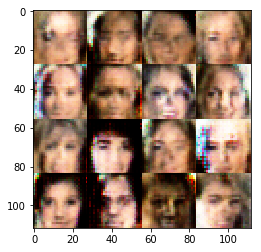

Epoch 1/2 - trainstep 710:   DiscriminatorLoss: 1.4267   GeneratorLoss    : 0.7135
Epoch 1/2 - trainstep 720:   DiscriminatorLoss: 1.4134   GeneratorLoss    : 0.6381
Epoch 1/2 - trainstep 730:   DiscriminatorLoss: 1.4082   GeneratorLoss    : 0.7088
Epoch 1/2 - trainstep 740:   DiscriminatorLoss: 1.2777   GeneratorLoss    : 0.7880
Epoch 1/2 - trainstep 750:   DiscriminatorLoss: 1.6562   GeneratorLoss    : 1.7716
Epoch 1/2 - trainstep 760:   DiscriminatorLoss: 1.3866   GeneratorLoss    : 0.8334
Epoch 1/2 - trainstep 770:   DiscriminatorLoss: 1.3521   GeneratorLoss    : 1.0185
Epoch 1/2 - trainstep 780:   DiscriminatorLoss: 1.6398   GeneratorLoss    : 0.3645
Epoch 1/2 - trainstep 790:   DiscriminatorLoss: 1.4350   GeneratorLoss    : 0.7008
Epoch 1/2 - trainstep 800:   DiscriminatorLoss: 1.3039   GeneratorLoss    : 1.1198


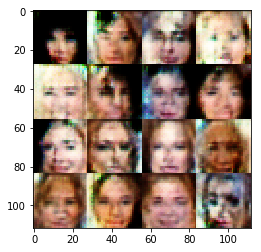

Epoch 1/2 - trainstep 810:   DiscriminatorLoss: 1.2736   GeneratorLoss    : 0.7967
Epoch 1/2 - trainstep 820:   DiscriminatorLoss: 1.4678   GeneratorLoss    : 1.6062
Epoch 1/2 - trainstep 830:   DiscriminatorLoss: 1.3996   GeneratorLoss    : 0.7021
Epoch 1/2 - trainstep 840:   DiscriminatorLoss: 1.3784   GeneratorLoss    : 0.9866
Epoch 1/2 - trainstep 850:   DiscriminatorLoss: 1.4706   GeneratorLoss    : 0.6126
Epoch 1/2 - trainstep 860:   DiscriminatorLoss: 1.4024   GeneratorLoss    : 0.5088
Epoch 1/2 - trainstep 870:   DiscriminatorLoss: 1.3357   GeneratorLoss    : 0.9039
Epoch 1/2 - trainstep 880:   DiscriminatorLoss: 1.3677   GeneratorLoss    : 1.1896
Epoch 1/2 - trainstep 890:   DiscriminatorLoss: 1.4219   GeneratorLoss    : 0.8483
Epoch 1/2 - trainstep 900:   DiscriminatorLoss: 1.6751   GeneratorLoss    : 0.3466


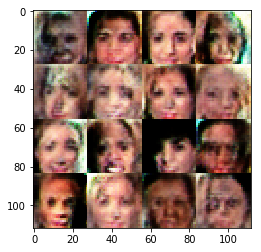

Epoch 1/2 - trainstep 910:   DiscriminatorLoss: 1.3781   GeneratorLoss    : 0.6826
Epoch 1/2 - trainstep 920:   DiscriminatorLoss: 1.4900   GeneratorLoss    : 0.5942
Epoch 1/2 - trainstep 930:   DiscriminatorLoss: 1.3291   GeneratorLoss    : 0.8366
Epoch 1/2 - trainstep 940:   DiscriminatorLoss: 1.3041   GeneratorLoss    : 0.7722
Epoch 1/2 - trainstep 950:   DiscriminatorLoss: 1.3661   GeneratorLoss    : 0.6751
Epoch 1/2 - trainstep 960:   DiscriminatorLoss: 1.3725   GeneratorLoss    : 0.9313
Epoch 1/2 - trainstep 970:   DiscriminatorLoss: 1.3630   GeneratorLoss    : 0.8945
Epoch 1/2 - trainstep 980:   DiscriminatorLoss: 1.3553   GeneratorLoss    : 0.7680
Epoch 1/2 - trainstep 990:   DiscriminatorLoss: 1.3078   GeneratorLoss    : 0.9034
Epoch 1/2 - trainstep 1000:   DiscriminatorLoss: 1.5789   GeneratorLoss    : 0.4199


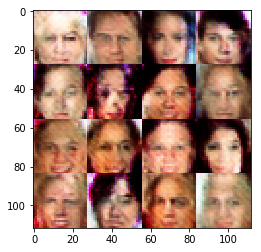

Epoch 1/2 - trainstep 1010:   DiscriminatorLoss: 1.4203   GeneratorLoss    : 0.7428
Epoch 1/2 - trainstep 1020:   DiscriminatorLoss: 1.4348   GeneratorLoss    : 0.5527
Epoch 1/2 - trainstep 1030:   DiscriminatorLoss: 1.4743   GeneratorLoss    : 1.3885
Epoch 1/2 - trainstep 1040:   DiscriminatorLoss: 1.4337   GeneratorLoss    : 0.6476
Epoch 1/2 - trainstep 1050:   DiscriminatorLoss: 1.2661   GeneratorLoss    : 0.7684
Epoch 1/2 - trainstep 1060:   DiscriminatorLoss: 1.3912   GeneratorLoss    : 0.7467
Epoch 1/2 - trainstep 1070:   DiscriminatorLoss: 1.4545   GeneratorLoss    : 0.5074
Epoch 1/2 - trainstep 1080:   DiscriminatorLoss: 1.3090   GeneratorLoss    : 0.8614
Epoch 1/2 - trainstep 1090:   DiscriminatorLoss: 1.4548   GeneratorLoss    : 0.6649
Epoch 1/2 - trainstep 1100:   DiscriminatorLoss: 1.2919   GeneratorLoss    : 0.7609


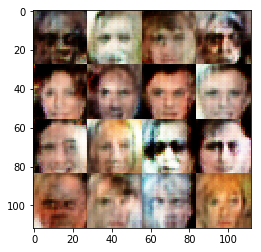

Epoch 1/2 - trainstep 1110:   DiscriminatorLoss: 1.3983   GeneratorLoss    : 1.1022
Epoch 1/2 - trainstep 1120:   DiscriminatorLoss: 1.2941   GeneratorLoss    : 0.7247
Epoch 1/2 - trainstep 1130:   DiscriminatorLoss: 1.4033   GeneratorLoss    : 0.8593
Epoch 1/2 - trainstep 1140:   DiscriminatorLoss: 1.4080   GeneratorLoss    : 0.6638
Epoch 1/2 - trainstep 1150:   DiscriminatorLoss: 1.4352   GeneratorLoss    : 0.6651
Epoch 1/2 - trainstep 1160:   DiscriminatorLoss: 1.3152   GeneratorLoss    : 0.9041
Epoch 1/2 - trainstep 1170:   DiscriminatorLoss: 1.3884   GeneratorLoss    : 0.6975
Epoch 1/2 - trainstep 1180:   DiscriminatorLoss: 1.3349   GeneratorLoss    : 0.8496
Epoch 1/2 - trainstep 1190:   DiscriminatorLoss: 1.4050   GeneratorLoss    : 0.8484
Epoch 1/2 - trainstep 1200:   DiscriminatorLoss: 1.3335   GeneratorLoss    : 0.6931


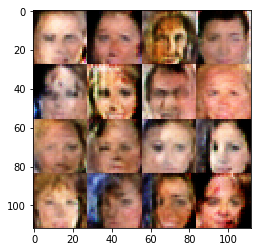

Epoch 1/2 - trainstep 1210:   DiscriminatorLoss: 1.5052   GeneratorLoss    : 0.8032
Epoch 1/2 - trainstep 1220:   DiscriminatorLoss: 1.3848   GeneratorLoss    : 0.8681
Epoch 1/2 - trainstep 1230:   DiscriminatorLoss: 1.3732   GeneratorLoss    : 0.7988
Epoch 1/2 - trainstep 1240:   DiscriminatorLoss: 1.3351   GeneratorLoss    : 0.8323
Epoch 1/2 - trainstep 1250:   DiscriminatorLoss: 1.4108   GeneratorLoss    : 1.0518
Epoch 1/2 - trainstep 1260:   DiscriminatorLoss: 1.4810   GeneratorLoss    : 0.9088
Epoch 1/2 - trainstep 1270:   DiscriminatorLoss: 1.3642   GeneratorLoss    : 0.7750
Epoch 1/2 - trainstep 1280:   DiscriminatorLoss: 1.4369   GeneratorLoss    : 0.5182
Epoch 1/2 - trainstep 1290:   DiscriminatorLoss: 1.3428   GeneratorLoss    : 0.8396
Epoch 1/2 - trainstep 1300:   DiscriminatorLoss: 1.2902   GeneratorLoss    : 0.7471


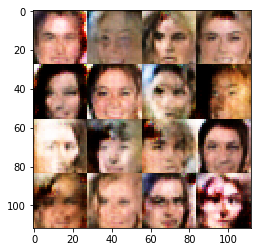

Epoch 1/2 - trainstep 1310:   DiscriminatorLoss: 1.5095   GeneratorLoss    : 0.6576
Epoch 1/2 - trainstep 1320:   DiscriminatorLoss: 1.3095   GeneratorLoss    : 0.6761
Epoch 1/2 - trainstep 1330:   DiscriminatorLoss: 1.3511   GeneratorLoss    : 0.7273
Epoch 1/2 - trainstep 1340:   DiscriminatorLoss: 1.3680   GeneratorLoss    : 0.9124
Epoch 1/2 - trainstep 1350:   DiscriminatorLoss: 1.4980   GeneratorLoss    : 0.9221
Epoch 1/2 - trainstep 1360:   DiscriminatorLoss: 1.3625   GeneratorLoss    : 0.6862
Epoch 1/2 - trainstep 1370:   DiscriminatorLoss: 1.5363   GeneratorLoss    : 1.4795
Epoch 1/2 - trainstep 1380:   DiscriminatorLoss: 1.3785   GeneratorLoss    : 0.8687
Epoch 1/2 - trainstep 1390:   DiscriminatorLoss: 1.5099   GeneratorLoss    : 0.4816
Epoch 1/2 - trainstep 1400:   DiscriminatorLoss: 1.4444   GeneratorLoss    : 0.8396


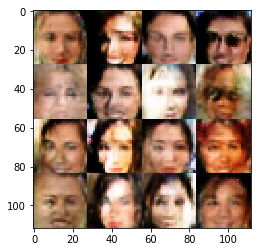

Epoch 1/2 - trainstep 1410:   DiscriminatorLoss: 1.3141   GeneratorLoss    : 0.8245
Epoch 1/2 - trainstep 1420:   DiscriminatorLoss: 1.3352   GeneratorLoss    : 0.7789
Epoch 1/2 - trainstep 1430:   DiscriminatorLoss: 1.2201   GeneratorLoss    : 0.8415
Epoch 1/2 - trainstep 1440:   DiscriminatorLoss: 1.4246   GeneratorLoss    : 0.5737
Epoch 1/2 - trainstep 1450:   DiscriminatorLoss: 1.3847   GeneratorLoss    : 0.7086
Epoch 1/2 - trainstep 1460:   DiscriminatorLoss: 1.3945   GeneratorLoss    : 0.8624
Epoch 1/2 - trainstep 1470:   DiscriminatorLoss: 1.3889   GeneratorLoss    : 0.5904
Epoch 1/2 - trainstep 1480:   DiscriminatorLoss: 1.3232   GeneratorLoss    : 1.1009
Epoch 1/2 - trainstep 1490:   DiscriminatorLoss: 1.2921   GeneratorLoss    : 0.8326
Epoch 1/2 - trainstep 1500:   DiscriminatorLoss: 1.3091   GeneratorLoss    : 0.7766


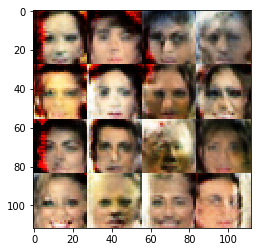

Epoch 1/2 - trainstep 1510:   DiscriminatorLoss: 1.3272   GeneratorLoss    : 0.7693
Epoch 1/2 - trainstep 1520:   DiscriminatorLoss: 1.4569   GeneratorLoss    : 0.5376
Epoch 1/2 - trainstep 1530:   DiscriminatorLoss: 1.4054   GeneratorLoss    : 0.9011
Epoch 1/2 - trainstep 1540:   DiscriminatorLoss: 1.4110   GeneratorLoss    : 0.5202
Epoch 1/2 - trainstep 1550:   DiscriminatorLoss: 1.4142   GeneratorLoss    : 0.7528
Epoch 1/2 - trainstep 1560:   DiscriminatorLoss: 1.3299   GeneratorLoss    : 0.8189
Epoch 1/2 - trainstep 1570:   DiscriminatorLoss: 1.3146   GeneratorLoss    : 0.7116
Epoch 1/2 - trainstep 1580:   DiscriminatorLoss: 1.4585   GeneratorLoss    : 0.5660
Epoch 1/2 - trainstep 1590:   DiscriminatorLoss: 1.3586   GeneratorLoss    : 0.8837
Epoch 1/2 - trainstep 1600:   DiscriminatorLoss: 1.3414   GeneratorLoss    : 0.7595


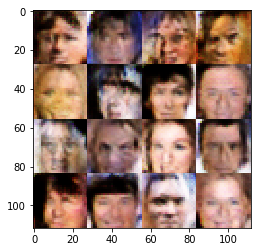

Epoch 1/2 - trainstep 1610:   DiscriminatorLoss: 1.4684   GeneratorLoss    : 0.7583
Epoch 1/2 - trainstep 1620:   DiscriminatorLoss: 1.2287   GeneratorLoss    : 1.0199
Epoch 1/2 - trainstep 1630:   DiscriminatorLoss: 1.4439   GeneratorLoss    : 0.9643
Epoch 1/2 - trainstep 1640:   DiscriminatorLoss: 1.3690   GeneratorLoss    : 0.6701
Epoch 1/2 - trainstep 1650:   DiscriminatorLoss: 1.4431   GeneratorLoss    : 0.8480
Epoch 1/2 - trainstep 1660:   DiscriminatorLoss: 1.4226   GeneratorLoss    : 0.8851
Epoch 1/2 - trainstep 1670:   DiscriminatorLoss: 1.4043   GeneratorLoss    : 0.9274
Epoch 1/2 - trainstep 1680:   DiscriminatorLoss: 1.3279   GeneratorLoss    : 0.7548
Epoch 1/2 - trainstep 1690:   DiscriminatorLoss: 1.3745   GeneratorLoss    : 0.6425
Epoch 1/2 - trainstep 1700:   DiscriminatorLoss: 1.4380   GeneratorLoss    : 0.7741


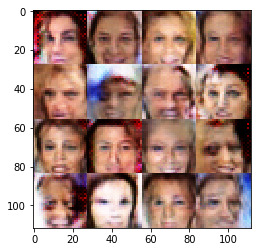

Epoch 1/2 - trainstep 1710:   DiscriminatorLoss: 1.3200   GeneratorLoss    : 0.6665
Epoch 1/2 - trainstep 1720:   DiscriminatorLoss: 1.2979   GeneratorLoss    : 0.8137
Epoch 1/2 - trainstep 1730:   DiscriminatorLoss: 1.3607   GeneratorLoss    : 1.0017
Epoch 1/2 - trainstep 1740:   DiscriminatorLoss: 1.5351   GeneratorLoss    : 0.4918
Epoch 1/2 - trainstep 1750:   DiscriminatorLoss: 1.4268   GeneratorLoss    : 0.6276
Epoch 1/2 - trainstep 1760:   DiscriminatorLoss: 1.3940   GeneratorLoss    : 0.8704
Epoch 1/2 - trainstep 1770:   DiscriminatorLoss: 1.3446   GeneratorLoss    : 0.7085
Epoch 1/2 - trainstep 1780:   DiscriminatorLoss: 1.3830   GeneratorLoss    : 0.7419
Epoch 1/2 - trainstep 1790:   DiscriminatorLoss: 1.2866   GeneratorLoss    : 0.9049
Epoch 1/2 - trainstep 1800:   DiscriminatorLoss: 1.3977   GeneratorLoss    : 0.7705


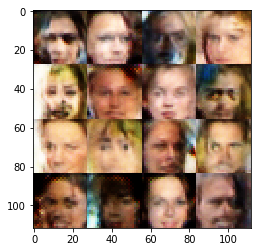

Epoch 1/2 - trainstep 1810:   DiscriminatorLoss: 1.3968   GeneratorLoss    : 0.7400
Epoch 1/2 - trainstep 1820:   DiscriminatorLoss: 1.3438   GeneratorLoss    : 0.7371
Epoch 1/2 - trainstep 1830:   DiscriminatorLoss: 1.3500   GeneratorLoss    : 0.6840
Epoch 1/2 - trainstep 1840:   DiscriminatorLoss: 1.4274   GeneratorLoss    : 0.7747
Epoch 1/2 - trainstep 1850:   DiscriminatorLoss: 1.3393   GeneratorLoss    : 0.7596
Epoch 1/2 - trainstep 1860:   DiscriminatorLoss: 1.3855   GeneratorLoss    : 0.6600
Epoch 1/2 - trainstep 1870:   DiscriminatorLoss: 1.3659   GeneratorLoss    : 0.7011
Epoch 1/2 - trainstep 1880:   DiscriminatorLoss: 1.3307   GeneratorLoss    : 1.0338
Epoch 1/2 - trainstep 1890:   DiscriminatorLoss: 1.3253   GeneratorLoss    : 0.6875
Epoch 1/2 - trainstep 1900:   DiscriminatorLoss: 1.4556   GeneratorLoss    : 0.5872


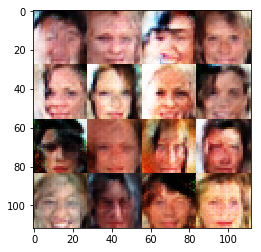

Epoch 1/2 - trainstep 1910:   DiscriminatorLoss: 1.4066   GeneratorLoss    : 0.9094
Epoch 1/2 - trainstep 1920:   DiscriminatorLoss: 1.2463   GeneratorLoss    : 0.9418
Epoch 1/2 - trainstep 1930:   DiscriminatorLoss: 1.3366   GeneratorLoss    : 0.8141
Epoch 1/2 - trainstep 1940:   DiscriminatorLoss: 1.3719   GeneratorLoss    : 0.7177
Epoch 1/2 - trainstep 1950:   DiscriminatorLoss: 1.3098   GeneratorLoss    : 0.8474
Epoch 1/2 - trainstep 1960:   DiscriminatorLoss: 1.4447   GeneratorLoss    : 0.4860
Epoch 1/2 - trainstep 1970:   DiscriminatorLoss: 1.3453   GeneratorLoss    : 0.8475
Epoch 1/2 - trainstep 1980:   DiscriminatorLoss: 1.2486   GeneratorLoss    : 1.0890
Epoch 1/2 - trainstep 1990:   DiscriminatorLoss: 1.3215   GeneratorLoss    : 0.8708
Epoch 1/2 - trainstep 2000:   DiscriminatorLoss: 1.5400   GeneratorLoss    : 0.4956


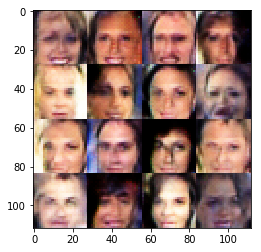

Epoch 1/2 - trainstep 2010:   DiscriminatorLoss: 1.2626   GeneratorLoss    : 0.8507
Epoch 1/2 - trainstep 2020:   DiscriminatorLoss: 1.4127   GeneratorLoss    : 0.7785
Epoch 1/2 - trainstep 2030:   DiscriminatorLoss: 1.5177   GeneratorLoss    : 0.5705
Epoch 1/2 - trainstep 2040:   DiscriminatorLoss: 1.3692   GeneratorLoss    : 0.8040
Epoch 1/2 - trainstep 2050:   DiscriminatorLoss: 1.3468   GeneratorLoss    : 0.8826
Epoch 1/2 - trainstep 2060:   DiscriminatorLoss: 1.3014   GeneratorLoss    : 0.8428
Epoch 1/2 - trainstep 2070:   DiscriminatorLoss: 1.3894   GeneratorLoss    : 0.6212
Epoch 1/2 - trainstep 2080:   DiscriminatorLoss: 1.4091   GeneratorLoss    : 0.5889
Epoch 1/2 - trainstep 2090:   DiscriminatorLoss: 1.3980   GeneratorLoss    : 0.6079
Epoch 1/2 - trainstep 2100:   DiscriminatorLoss: 1.4173   GeneratorLoss    : 0.9233


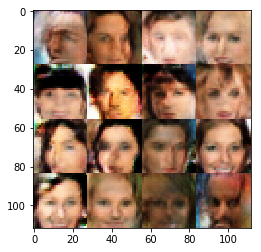

Epoch 1/2 - trainstep 2110:   DiscriminatorLoss: 1.4209   GeneratorLoss    : 0.6834
Epoch 1/2 - trainstep 2120:   DiscriminatorLoss: 1.2952   GeneratorLoss    : 0.8695
Epoch 1/2 - trainstep 2130:   DiscriminatorLoss: 1.4723   GeneratorLoss    : 0.5878
Epoch 1/2 - trainstep 2140:   DiscriminatorLoss: 1.4198   GeneratorLoss    : 0.7378
Epoch 1/2 - trainstep 2150:   DiscriminatorLoss: 1.3713   GeneratorLoss    : 0.6900
Epoch 1/2 - trainstep 2160:   DiscriminatorLoss: 1.3797   GeneratorLoss    : 0.6695
Epoch 1/2 - trainstep 2170:   DiscriminatorLoss: 1.3382   GeneratorLoss    : 0.8853
Epoch 1/2 - trainstep 2180:   DiscriminatorLoss: 1.5349   GeneratorLoss    : 1.1812
Epoch 1/2 - trainstep 2190:   DiscriminatorLoss: 1.4444   GeneratorLoss    : 0.6378
Epoch 1/2 - trainstep 2200:   DiscriminatorLoss: 1.3210   GeneratorLoss    : 0.7041


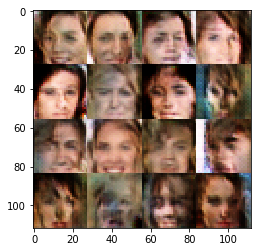

Epoch 1/2 - trainstep 2210:   DiscriminatorLoss: 1.4396   GeneratorLoss    : 0.7052
Epoch 1/2 - trainstep 2220:   DiscriminatorLoss: 1.4201   GeneratorLoss    : 0.8087
Epoch 1/2 - trainstep 2230:   DiscriminatorLoss: 1.3158   GeneratorLoss    : 0.8252
Epoch 1/2 - trainstep 2240:   DiscriminatorLoss: 1.3240   GeneratorLoss    : 0.8688
Epoch 1/2 - trainstep 2250:   DiscriminatorLoss: 1.3551   GeneratorLoss    : 0.7401
Epoch 1/2 - trainstep 2260:   DiscriminatorLoss: 1.3524   GeneratorLoss    : 0.9115
Epoch 1/2 - trainstep 2270:   DiscriminatorLoss: 1.4040   GeneratorLoss    : 0.7999
Epoch 1/2 - trainstep 2280:   DiscriminatorLoss: 1.3405   GeneratorLoss    : 0.8074
Epoch 1/2 - trainstep 2290:   DiscriminatorLoss: 1.3531   GeneratorLoss    : 0.8301
Epoch 1/2 - trainstep 2300:   DiscriminatorLoss: 1.4379   GeneratorLoss    : 0.9169


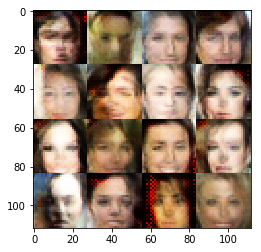

Epoch 1/2 - trainstep 2310:   DiscriminatorLoss: 1.4689   GeneratorLoss    : 0.6187
Epoch 1/2 - trainstep 2320:   DiscriminatorLoss: 1.3686   GeneratorLoss    : 0.7439
Epoch 1/2 - trainstep 2330:   DiscriminatorLoss: 1.4216   GeneratorLoss    : 0.6600
Epoch 1/2 - trainstep 2340:   DiscriminatorLoss: 1.3227   GeneratorLoss    : 0.7753
Epoch 1/2 - trainstep 2350:   DiscriminatorLoss: 1.4473   GeneratorLoss    : 0.7468
Epoch 1/2 - trainstep 2360:   DiscriminatorLoss: 1.5108   GeneratorLoss    : 0.5291
Epoch 1/2 - trainstep 2370:   DiscriminatorLoss: 1.2118   GeneratorLoss    : 0.9352
Epoch 1/2 - trainstep 2380:   DiscriminatorLoss: 1.4596   GeneratorLoss    : 0.7756
Epoch 1/2 - trainstep 2390:   DiscriminatorLoss: 1.3604   GeneratorLoss    : 0.6852
Epoch 1/2 - trainstep 2400:   DiscriminatorLoss: 1.3421   GeneratorLoss    : 0.8453


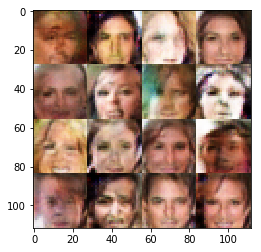

Epoch 1/2 - trainstep 2410:   DiscriminatorLoss: 1.2905   GeneratorLoss    : 0.9253
Epoch 1/2 - trainstep 2420:   DiscriminatorLoss: 1.3642   GeneratorLoss    : 0.7039
Epoch 1/2 - trainstep 2430:   DiscriminatorLoss: 1.3707   GeneratorLoss    : 0.8655
Epoch 1/2 - trainstep 2440:   DiscriminatorLoss: 1.3212   GeneratorLoss    : 0.6683
Epoch 1/2 - trainstep 2450:   DiscriminatorLoss: 1.3735   GeneratorLoss    : 0.8002
Epoch 1/2 - trainstep 2460:   DiscriminatorLoss: 1.3970   GeneratorLoss    : 0.7247
Epoch 1/2 - trainstep 2470:   DiscriminatorLoss: 1.3918   GeneratorLoss    : 0.7166
Epoch 1/2 - trainstep 2480:   DiscriminatorLoss: 1.3828   GeneratorLoss    : 0.8760
Epoch 1/2 - trainstep 2490:   DiscriminatorLoss: 1.2645   GeneratorLoss    : 0.9419
Epoch 1/2 - trainstep 2500:   DiscriminatorLoss: 1.3736   GeneratorLoss    : 0.7693


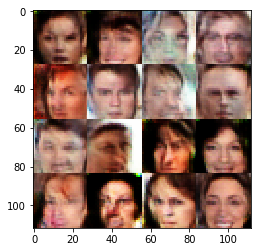

Epoch 1/2 - trainstep 2510:   DiscriminatorLoss: 1.3530   GeneratorLoss    : 0.8262
Epoch 1/2 - trainstep 2520:   DiscriminatorLoss: 1.3789   GeneratorLoss    : 0.7241
Epoch 1/2 - trainstep 2530:   DiscriminatorLoss: 1.3629   GeneratorLoss    : 0.7280
Epoch 1/2 - trainstep 2540:   DiscriminatorLoss: 1.4265   GeneratorLoss    : 0.7948
Epoch 1/2 - trainstep 2550:   DiscriminatorLoss: 1.3661   GeneratorLoss    : 0.6615
Epoch 1/2 - trainstep 2560:   DiscriminatorLoss: 1.3638   GeneratorLoss    : 0.7700
Epoch 1/2 - trainstep 2570:   DiscriminatorLoss: 1.4356   GeneratorLoss    : 0.6895
Epoch 1/2 - trainstep 2580:   DiscriminatorLoss: 1.3725   GeneratorLoss    : 0.6989
Epoch 1/2 - trainstep 2590:   DiscriminatorLoss: 1.4460   GeneratorLoss    : 0.6438
Epoch 1/2 - trainstep 2600:   DiscriminatorLoss: 1.4662   GeneratorLoss    : 0.8313


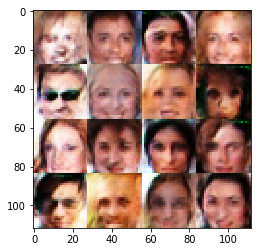

Epoch 1/2 - trainstep 2610:   DiscriminatorLoss: 1.3602   GeneratorLoss    : 0.8270
Epoch 1/2 - trainstep 2620:   DiscriminatorLoss: 1.3907   GeneratorLoss    : 0.7962
Epoch 1/2 - trainstep 2630:   DiscriminatorLoss: 1.3734   GeneratorLoss    : 0.7135
Epoch 1/2 - trainstep 2640:   DiscriminatorLoss: 1.4186   GeneratorLoss    : 0.7557
Epoch 1/2 - trainstep 2650:   DiscriminatorLoss: 1.2611   GeneratorLoss    : 0.9347
Epoch 1/2 - trainstep 2660:   DiscriminatorLoss: 1.4391   GeneratorLoss    : 1.0419
Epoch 1/2 - trainstep 2670:   DiscriminatorLoss: 1.2889   GeneratorLoss    : 0.8639
Epoch 1/2 - trainstep 2680:   DiscriminatorLoss: 1.3766   GeneratorLoss    : 0.7578
Epoch 1/2 - trainstep 2690:   DiscriminatorLoss: 1.4567   GeneratorLoss    : 0.7083
Epoch 1/2 - trainstep 2700:   DiscriminatorLoss: 1.3045   GeneratorLoss    : 1.0253


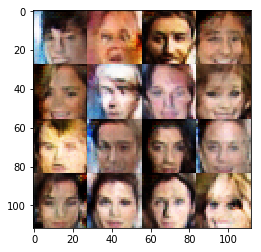

Epoch 1/2 - trainstep 2710:   DiscriminatorLoss: 1.2603   GeneratorLoss    : 0.7896
Epoch 1/2 - trainstep 2720:   DiscriminatorLoss: 1.4402   GeneratorLoss    : 0.6319
Epoch 1/2 - trainstep 2730:   DiscriminatorLoss: 1.4135   GeneratorLoss    : 0.7503
Epoch 1/2 - trainstep 2740:   DiscriminatorLoss: 1.4185   GeneratorLoss    : 0.8743
Epoch 1/2 - trainstep 2750:   DiscriminatorLoss: 1.2946   GeneratorLoss    : 0.7347
Epoch 1/2 - trainstep 2760:   DiscriminatorLoss: 1.4462   GeneratorLoss    : 0.5566
Epoch 1/2 - trainstep 2770:   DiscriminatorLoss: 1.3587   GeneratorLoss    : 0.7648
Epoch 1/2 - trainstep 2780:   DiscriminatorLoss: 1.3716   GeneratorLoss    : 0.6929
Epoch 1/2 - trainstep 2790:   DiscriminatorLoss: 1.4424   GeneratorLoss    : 0.6338
Epoch 1/2 - trainstep 2800:   DiscriminatorLoss: 1.2874   GeneratorLoss    : 0.7757


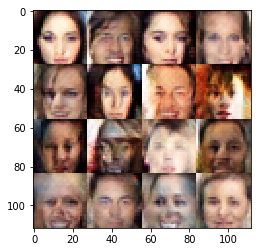

Epoch 1/2 - trainstep 2810:   DiscriminatorLoss: 1.3323   GeneratorLoss    : 0.6600
Epoch 1/2 - trainstep 2820:   DiscriminatorLoss: 1.4830   GeneratorLoss    : 0.7310
Epoch 1/2 - trainstep 2830:   DiscriminatorLoss: 1.3985   GeneratorLoss    : 0.6728
Epoch 1/2 - trainstep 2840:   DiscriminatorLoss: 1.4624   GeneratorLoss    : 0.6256
Epoch 1/2 - trainstep 2850:   DiscriminatorLoss: 1.3154   GeneratorLoss    : 0.7811
Epoch 1/2 - trainstep 2860:   DiscriminatorLoss: 1.2941   GeneratorLoss    : 0.7531
Epoch 1/2 - trainstep 2870:   DiscriminatorLoss: 1.4262   GeneratorLoss    : 0.6342
Epoch 1/2 - trainstep 2880:   DiscriminatorLoss: 1.3899   GeneratorLoss    : 0.7027
Epoch 1/2 - trainstep 2890:   DiscriminatorLoss: 1.4395   GeneratorLoss    : 0.7971
Epoch 1/2 - trainstep 2900:   DiscriminatorLoss: 1.3461   GeneratorLoss    : 0.7722


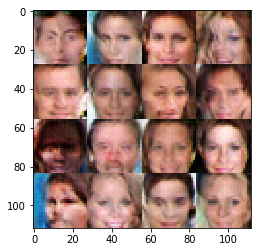

Epoch 1/2 - trainstep 2910:   DiscriminatorLoss: 1.3948   GeneratorLoss    : 0.7063
Epoch 1/2 - trainstep 2920:   DiscriminatorLoss: 1.3017   GeneratorLoss    : 0.7894
Epoch 1/2 - trainstep 2930:   DiscriminatorLoss: 1.3827   GeneratorLoss    : 0.8256
Epoch 1/2 - trainstep 2940:   DiscriminatorLoss: 1.3086   GeneratorLoss    : 0.7531
Epoch 1/2 - trainstep 2950:   DiscriminatorLoss: 1.3994   GeneratorLoss    : 0.8534
Epoch 1/2 - trainstep 2960:   DiscriminatorLoss: 1.4083   GeneratorLoss    : 0.7131
Epoch 1/2 - trainstep 2970:   DiscriminatorLoss: 1.3634   GeneratorLoss    : 0.7002
Epoch 1/2 - trainstep 2980:   DiscriminatorLoss: 1.2832   GeneratorLoss    : 0.8088
Epoch 1/2 - trainstep 2990:   DiscriminatorLoss: 1.3707   GeneratorLoss    : 0.6539
Epoch 1/2 - trainstep 3000:   DiscriminatorLoss: 1.2930   GeneratorLoss    : 0.7647


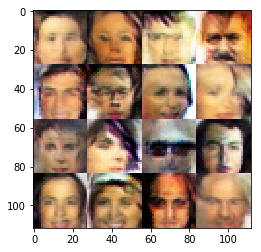

Epoch 1/2 - trainstep 3010:   DiscriminatorLoss: 1.3615   GeneratorLoss    : 0.8442
Epoch 1/2 - trainstep 3020:   DiscriminatorLoss: 1.3328   GeneratorLoss    : 0.6581
Epoch 1/2 - trainstep 3030:   DiscriminatorLoss: 1.3304   GeneratorLoss    : 0.8628
Epoch 1/2 - trainstep 3040:   DiscriminatorLoss: 1.4570   GeneratorLoss    : 0.6685
Epoch 1/2 - trainstep 3050:   DiscriminatorLoss: 1.4241   GeneratorLoss    : 0.7460
Epoch 1/2 - trainstep 3060:   DiscriminatorLoss: 1.3395   GeneratorLoss    : 0.7847
Epoch 1/2 - trainstep 3070:   DiscriminatorLoss: 1.3337   GeneratorLoss    : 0.6721
Epoch 1/2 - trainstep 3080:   DiscriminatorLoss: 1.2670   GeneratorLoss    : 0.8690
Epoch 1/2 - trainstep 3090:   DiscriminatorLoss: 1.4067   GeneratorLoss    : 0.7358
Epoch 1/2 - trainstep 3100:   DiscriminatorLoss: 1.4245   GeneratorLoss    : 0.6924


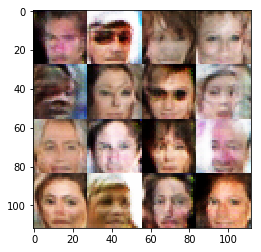

Epoch 1/2 - trainstep 3110:   DiscriminatorLoss: 1.4359   GeneratorLoss    : 0.6158
Epoch 1/2 - trainstep 3120:   DiscriminatorLoss: 1.3296   GeneratorLoss    : 0.7464
Epoch 1/2 - trainstep 3130:   DiscriminatorLoss: 1.3487   GeneratorLoss    : 0.6626
Epoch 1/2 - trainstep 3140:   DiscriminatorLoss: 1.4755   GeneratorLoss    : 0.6933
Epoch 1/2 - trainstep 3150:   DiscriminatorLoss: 1.3937   GeneratorLoss    : 0.7774
Epoch 1/2 - trainstep 3160:   DiscriminatorLoss: 1.4549   GeneratorLoss    : 0.6890
Epoch 2/2 - trainstep 3170:   DiscriminatorLoss: 1.4197   GeneratorLoss    : 0.7696
Epoch 2/2 - trainstep 3180:   DiscriminatorLoss: 1.4017   GeneratorLoss    : 0.7382
Epoch 2/2 - trainstep 3190:   DiscriminatorLoss: 1.4210   GeneratorLoss    : 0.6409
Epoch 2/2 - trainstep 3200:   DiscriminatorLoss: 1.3308   GeneratorLoss    : 0.8795


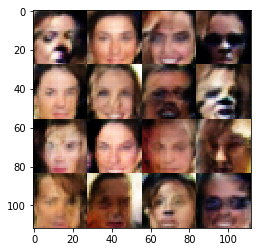

Epoch 2/2 - trainstep 3210:   DiscriminatorLoss: 1.3682   GeneratorLoss    : 0.7502
Epoch 2/2 - trainstep 3220:   DiscriminatorLoss: 1.4227   GeneratorLoss    : 0.8229
Epoch 2/2 - trainstep 3230:   DiscriminatorLoss: 1.4248   GeneratorLoss    : 0.7993
Epoch 2/2 - trainstep 3240:   DiscriminatorLoss: 1.3124   GeneratorLoss    : 0.7641
Epoch 2/2 - trainstep 3250:   DiscriminatorLoss: 1.3065   GeneratorLoss    : 0.9187
Epoch 2/2 - trainstep 3260:   DiscriminatorLoss: 1.3483   GeneratorLoss    : 0.7078
Epoch 2/2 - trainstep 3270:   DiscriminatorLoss: 1.3855   GeneratorLoss    : 0.7802
Epoch 2/2 - trainstep 3280:   DiscriminatorLoss: 1.2532   GeneratorLoss    : 0.7868
Epoch 2/2 - trainstep 3290:   DiscriminatorLoss: 1.3412   GeneratorLoss    : 0.7495
Epoch 2/2 - trainstep 3300:   DiscriminatorLoss: 1.3125   GeneratorLoss    : 0.7650


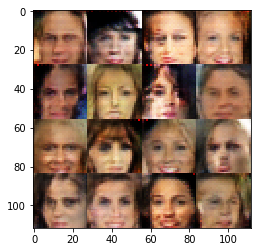

Epoch 2/2 - trainstep 3310:   DiscriminatorLoss: 1.4580   GeneratorLoss    : 0.6849
Epoch 2/2 - trainstep 3320:   DiscriminatorLoss: 1.3453   GeneratorLoss    : 0.7007
Epoch 2/2 - trainstep 3330:   DiscriminatorLoss: 1.3551   GeneratorLoss    : 0.8025
Epoch 2/2 - trainstep 3340:   DiscriminatorLoss: 1.3225   GeneratorLoss    : 0.7518
Epoch 2/2 - trainstep 3350:   DiscriminatorLoss: 1.3886   GeneratorLoss    : 0.7390
Epoch 2/2 - trainstep 3360:   DiscriminatorLoss: 1.4320   GeneratorLoss    : 0.7006
Epoch 2/2 - trainstep 3370:   DiscriminatorLoss: 1.2985   GeneratorLoss    : 0.9048
Epoch 2/2 - trainstep 3380:   DiscriminatorLoss: 1.3619   GeneratorLoss    : 0.6909
Epoch 2/2 - trainstep 3390:   DiscriminatorLoss: 1.4555   GeneratorLoss    : 0.7052
Epoch 2/2 - trainstep 3400:   DiscriminatorLoss: 1.4279   GeneratorLoss    : 0.6964


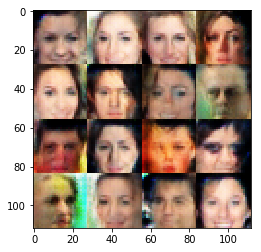

Epoch 2/2 - trainstep 3410:   DiscriminatorLoss: 1.4669   GeneratorLoss    : 0.6709
Epoch 2/2 - trainstep 3420:   DiscriminatorLoss: 1.4111   GeneratorLoss    : 0.7159
Epoch 2/2 - trainstep 3430:   DiscriminatorLoss: 1.3225   GeneratorLoss    : 0.8789
Epoch 2/2 - trainstep 3440:   DiscriminatorLoss: 1.4114   GeneratorLoss    : 0.7184
Epoch 2/2 - trainstep 3450:   DiscriminatorLoss: 1.4378   GeneratorLoss    : 0.7049
Epoch 2/2 - trainstep 3460:   DiscriminatorLoss: 1.4044   GeneratorLoss    : 0.7391
Epoch 2/2 - trainstep 3470:   DiscriminatorLoss: 1.3783   GeneratorLoss    : 0.8298
Epoch 2/2 - trainstep 3480:   DiscriminatorLoss: 1.3617   GeneratorLoss    : 0.9352
Epoch 2/2 - trainstep 3490:   DiscriminatorLoss: 1.4590   GeneratorLoss    : 0.7259
Epoch 2/2 - trainstep 3500:   DiscriminatorLoss: 1.2913   GeneratorLoss    : 0.8025


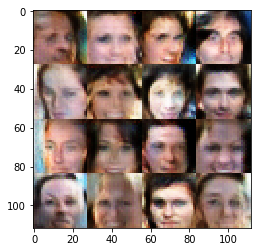

Epoch 2/2 - trainstep 3510:   DiscriminatorLoss: 1.3325   GeneratorLoss    : 0.7912
Epoch 2/2 - trainstep 3520:   DiscriminatorLoss: 1.2961   GeneratorLoss    : 0.8017
Epoch 2/2 - trainstep 3530:   DiscriminatorLoss: 1.3066   GeneratorLoss    : 0.8445
Epoch 2/2 - trainstep 3540:   DiscriminatorLoss: 1.4238   GeneratorLoss    : 0.6849
Epoch 2/2 - trainstep 3550:   DiscriminatorLoss: 1.3423   GeneratorLoss    : 0.7075
Epoch 2/2 - trainstep 3560:   DiscriminatorLoss: 1.4177   GeneratorLoss    : 0.6349
Epoch 2/2 - trainstep 3570:   DiscriminatorLoss: 1.3623   GeneratorLoss    : 0.7653
Epoch 2/2 - trainstep 3580:   DiscriminatorLoss: 1.3995   GeneratorLoss    : 0.7451
Epoch 2/2 - trainstep 3590:   DiscriminatorLoss: 1.4312   GeneratorLoss    : 0.7667
Epoch 2/2 - trainstep 3600:   DiscriminatorLoss: 1.3087   GeneratorLoss    : 0.8839


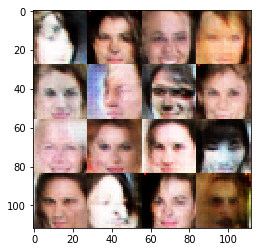

Epoch 2/2 - trainstep 3610:   DiscriminatorLoss: 1.3569   GeneratorLoss    : 0.7134
Epoch 2/2 - trainstep 3620:   DiscriminatorLoss: 1.4204   GeneratorLoss    : 0.6582
Epoch 2/2 - trainstep 3630:   DiscriminatorLoss: 1.3467   GeneratorLoss    : 0.7284
Epoch 2/2 - trainstep 3640:   DiscriminatorLoss: 1.4048   GeneratorLoss    : 0.7254
Epoch 2/2 - trainstep 3650:   DiscriminatorLoss: 1.3368   GeneratorLoss    : 0.8172
Epoch 2/2 - trainstep 3660:   DiscriminatorLoss: 1.3570   GeneratorLoss    : 0.7031
Epoch 2/2 - trainstep 3670:   DiscriminatorLoss: 1.4327   GeneratorLoss    : 0.7190
Epoch 2/2 - trainstep 3680:   DiscriminatorLoss: 1.3563   GeneratorLoss    : 0.7193
Epoch 2/2 - trainstep 3690:   DiscriminatorLoss: 1.2856   GeneratorLoss    : 0.7456
Epoch 2/2 - trainstep 3700:   DiscriminatorLoss: 1.3929   GeneratorLoss    : 0.7595


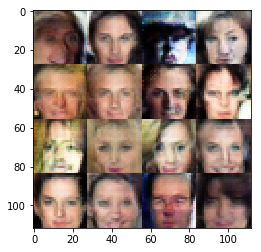

Epoch 2/2 - trainstep 3710:   DiscriminatorLoss: 1.2988   GeneratorLoss    : 0.7776
Epoch 2/2 - trainstep 3720:   DiscriminatorLoss: 1.2732   GeneratorLoss    : 0.8723
Epoch 2/2 - trainstep 3730:   DiscriminatorLoss: 1.2981   GeneratorLoss    : 0.8148
Epoch 2/2 - trainstep 3740:   DiscriminatorLoss: 1.4012   GeneratorLoss    : 0.7378
Epoch 2/2 - trainstep 3750:   DiscriminatorLoss: 1.3766   GeneratorLoss    : 0.7522
Epoch 2/2 - trainstep 3760:   DiscriminatorLoss: 1.3202   GeneratorLoss    : 0.7467
Epoch 2/2 - trainstep 3770:   DiscriminatorLoss: 1.3693   GeneratorLoss    : 0.6695
Epoch 2/2 - trainstep 3780:   DiscriminatorLoss: 1.3202   GeneratorLoss    : 0.8441
Epoch 2/2 - trainstep 3790:   DiscriminatorLoss: 1.3268   GeneratorLoss    : 0.7408
Epoch 2/2 - trainstep 3800:   DiscriminatorLoss: 1.3415   GeneratorLoss    : 0.9031


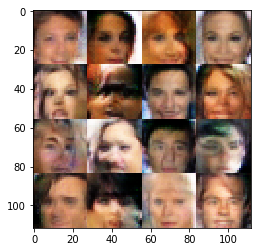

Epoch 2/2 - trainstep 3810:   DiscriminatorLoss: 1.3621   GeneratorLoss    : 0.7274
Epoch 2/2 - trainstep 3820:   DiscriminatorLoss: 1.4549   GeneratorLoss    : 0.7537
Epoch 2/2 - trainstep 3830:   DiscriminatorLoss: 1.4385   GeneratorLoss    : 0.7942
Epoch 2/2 - trainstep 3840:   DiscriminatorLoss: 1.3968   GeneratorLoss    : 0.7011
Epoch 2/2 - trainstep 3850:   DiscriminatorLoss: 1.3970   GeneratorLoss    : 0.6926
Epoch 2/2 - trainstep 3860:   DiscriminatorLoss: 1.3964   GeneratorLoss    : 0.7140
Epoch 2/2 - trainstep 3870:   DiscriminatorLoss: 1.4307   GeneratorLoss    : 0.7206
Epoch 2/2 - trainstep 3880:   DiscriminatorLoss: 1.3290   GeneratorLoss    : 0.7233
Epoch 2/2 - trainstep 3890:   DiscriminatorLoss: 1.3028   GeneratorLoss    : 0.7637
Epoch 2/2 - trainstep 3900:   DiscriminatorLoss: 1.3748   GeneratorLoss    : 0.7373


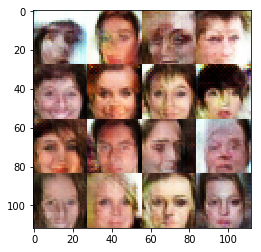

Epoch 2/2 - trainstep 3910:   DiscriminatorLoss: 1.4089   GeneratorLoss    : 0.6856
Epoch 2/2 - trainstep 3920:   DiscriminatorLoss: 1.3208   GeneratorLoss    : 0.7657
Epoch 2/2 - trainstep 3930:   DiscriminatorLoss: 1.3621   GeneratorLoss    : 0.7643
Epoch 2/2 - trainstep 3940:   DiscriminatorLoss: 1.3757   GeneratorLoss    : 0.7829
Epoch 2/2 - trainstep 3950:   DiscriminatorLoss: 1.4004   GeneratorLoss    : 0.7061
Epoch 2/2 - trainstep 3960:   DiscriminatorLoss: 1.3555   GeneratorLoss    : 0.7930
Epoch 2/2 - trainstep 3970:   DiscriminatorLoss: 1.3608   GeneratorLoss    : 0.7972
Epoch 2/2 - trainstep 3980:   DiscriminatorLoss: 1.4486   GeneratorLoss    : 0.6634
Epoch 2/2 - trainstep 3990:   DiscriminatorLoss: 1.4696   GeneratorLoss    : 0.6619
Epoch 2/2 - trainstep 4000:   DiscriminatorLoss: 1.3508   GeneratorLoss    : 0.7932


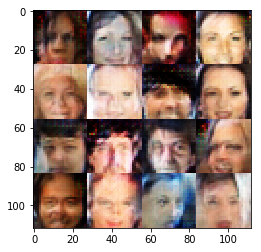

Epoch 2/2 - trainstep 4010:   DiscriminatorLoss: 1.2905   GeneratorLoss    : 0.8585
Epoch 2/2 - trainstep 4020:   DiscriminatorLoss: 1.3776   GeneratorLoss    : 0.7268
Epoch 2/2 - trainstep 4030:   DiscriminatorLoss: 1.4006   GeneratorLoss    : 0.7467
Epoch 2/2 - trainstep 4040:   DiscriminatorLoss: 1.3769   GeneratorLoss    : 0.7085
Epoch 2/2 - trainstep 4050:   DiscriminatorLoss: 1.3548   GeneratorLoss    : 0.8405
Epoch 2/2 - trainstep 4060:   DiscriminatorLoss: 1.3431   GeneratorLoss    : 0.7346
Epoch 2/2 - trainstep 4070:   DiscriminatorLoss: 1.4115   GeneratorLoss    : 0.6431
Epoch 2/2 - trainstep 4080:   DiscriminatorLoss: 1.3153   GeneratorLoss    : 0.8868
Epoch 2/2 - trainstep 4090:   DiscriminatorLoss: 1.3158   GeneratorLoss    : 0.8533
Epoch 2/2 - trainstep 4100:   DiscriminatorLoss: 1.3311   GeneratorLoss    : 0.8337


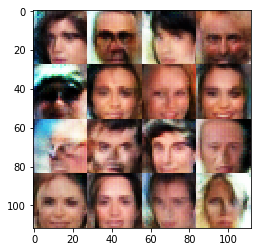

Epoch 2/2 - trainstep 4110:   DiscriminatorLoss: 1.3594   GeneratorLoss    : 0.8218
Epoch 2/2 - trainstep 4120:   DiscriminatorLoss: 1.3822   GeneratorLoss    : 0.7618
Epoch 2/2 - trainstep 4130:   DiscriminatorLoss: 1.4442   GeneratorLoss    : 0.7345
Epoch 2/2 - trainstep 4140:   DiscriminatorLoss: 1.3948   GeneratorLoss    : 0.6632
Epoch 2/2 - trainstep 4150:   DiscriminatorLoss: 1.4441   GeneratorLoss    : 0.6945
Epoch 2/2 - trainstep 4160:   DiscriminatorLoss: 1.4270   GeneratorLoss    : 0.8169
Epoch 2/2 - trainstep 4170:   DiscriminatorLoss: 1.3203   GeneratorLoss    : 0.8084
Epoch 2/2 - trainstep 4180:   DiscriminatorLoss: 1.4189   GeneratorLoss    : 0.7373
Epoch 2/2 - trainstep 4190:   DiscriminatorLoss: 1.3896   GeneratorLoss    : 0.7171
Epoch 2/2 - trainstep 4200:   DiscriminatorLoss: 1.3270   GeneratorLoss    : 0.7964


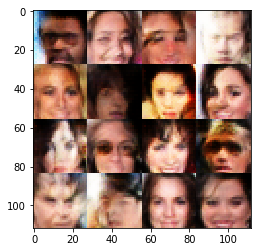

Epoch 2/2 - trainstep 4210:   DiscriminatorLoss: 1.3803   GeneratorLoss    : 0.7652
Epoch 2/2 - trainstep 4220:   DiscriminatorLoss: 1.3995   GeneratorLoss    : 0.7440
Epoch 2/2 - trainstep 4230:   DiscriminatorLoss: 1.3339   GeneratorLoss    : 0.8014
Epoch 2/2 - trainstep 4240:   DiscriminatorLoss: 1.3435   GeneratorLoss    : 0.8020
Epoch 2/2 - trainstep 4250:   DiscriminatorLoss: 1.4152   GeneratorLoss    : 0.7548
Epoch 2/2 - trainstep 4260:   DiscriminatorLoss: 1.4520   GeneratorLoss    : 0.7136
Epoch 2/2 - trainstep 4270:   DiscriminatorLoss: 1.3613   GeneratorLoss    : 0.8093
Epoch 2/2 - trainstep 4280:   DiscriminatorLoss: 1.3181   GeneratorLoss    : 0.7484
Epoch 2/2 - trainstep 4290:   DiscriminatorLoss: 1.2996   GeneratorLoss    : 0.7447
Epoch 2/2 - trainstep 4300:   DiscriminatorLoss: 1.3567   GeneratorLoss    : 0.8230


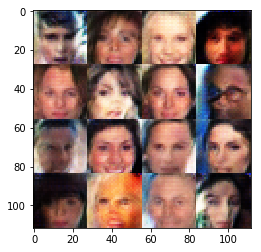

Epoch 2/2 - trainstep 4310:   DiscriminatorLoss: 1.3622   GeneratorLoss    : 0.7806
Epoch 2/2 - trainstep 4320:   DiscriminatorLoss: 1.3545   GeneratorLoss    : 0.7632
Epoch 2/2 - trainstep 4330:   DiscriminatorLoss: 1.3160   GeneratorLoss    : 0.8164
Epoch 2/2 - trainstep 4340:   DiscriminatorLoss: 1.3712   GeneratorLoss    : 0.7473
Epoch 2/2 - trainstep 4350:   DiscriminatorLoss: 1.3297   GeneratorLoss    : 0.7289
Epoch 2/2 - trainstep 4360:   DiscriminatorLoss: 1.4007   GeneratorLoss    : 0.6354
Epoch 2/2 - trainstep 4370:   DiscriminatorLoss: 1.3186   GeneratorLoss    : 0.7440
Epoch 2/2 - trainstep 4380:   DiscriminatorLoss: 1.3319   GeneratorLoss    : 0.7622
Epoch 2/2 - trainstep 4390:   DiscriminatorLoss: 1.3241   GeneratorLoss    : 0.7244
Epoch 2/2 - trainstep 4400:   DiscriminatorLoss: 1.3614   GeneratorLoss    : 0.8726


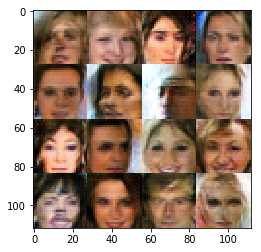

Epoch 2/2 - trainstep 4410:   DiscriminatorLoss: 1.3618   GeneratorLoss    : 0.7410
Epoch 2/2 - trainstep 4420:   DiscriminatorLoss: 1.3211   GeneratorLoss    : 0.7721
Epoch 2/2 - trainstep 4430:   DiscriminatorLoss: 1.2816   GeneratorLoss    : 0.8322
Epoch 2/2 - trainstep 4440:   DiscriminatorLoss: 1.3866   GeneratorLoss    : 0.7211
Epoch 2/2 - trainstep 4450:   DiscriminatorLoss: 1.3016   GeneratorLoss    : 0.7919
Epoch 2/2 - trainstep 4460:   DiscriminatorLoss: 1.3432   GeneratorLoss    : 0.7682
Epoch 2/2 - trainstep 4470:   DiscriminatorLoss: 1.3330   GeneratorLoss    : 0.7396
Epoch 2/2 - trainstep 4480:   DiscriminatorLoss: 1.3266   GeneratorLoss    : 0.8983
Epoch 2/2 - trainstep 4490:   DiscriminatorLoss: 1.3177   GeneratorLoss    : 0.6868
Epoch 2/2 - trainstep 4500:   DiscriminatorLoss: 1.4069   GeneratorLoss    : 0.7010


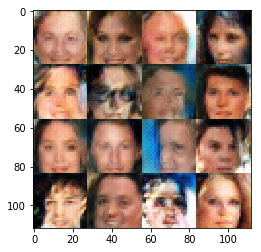

Epoch 2/2 - trainstep 4510:   DiscriminatorLoss: 1.3849   GeneratorLoss    : 0.6640
Epoch 2/2 - trainstep 4520:   DiscriminatorLoss: 1.3556   GeneratorLoss    : 0.7449
Epoch 2/2 - trainstep 4530:   DiscriminatorLoss: 1.3982   GeneratorLoss    : 0.7466
Epoch 2/2 - trainstep 4540:   DiscriminatorLoss: 1.3827   GeneratorLoss    : 0.6979
Epoch 2/2 - trainstep 4550:   DiscriminatorLoss: 1.3311   GeneratorLoss    : 0.6928
Epoch 2/2 - trainstep 4560:   DiscriminatorLoss: 1.3771   GeneratorLoss    : 0.7717
Epoch 2/2 - trainstep 4570:   DiscriminatorLoss: 1.4816   GeneratorLoss    : 0.7100
Epoch 2/2 - trainstep 4580:   DiscriminatorLoss: 1.3613   GeneratorLoss    : 0.6985
Epoch 2/2 - trainstep 4590:   DiscriminatorLoss: 1.3540   GeneratorLoss    : 0.8401
Epoch 2/2 - trainstep 4600:   DiscriminatorLoss: 1.2894   GeneratorLoss    : 0.7896


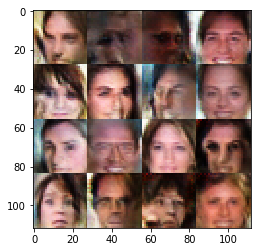

Epoch 2/2 - trainstep 4610:   DiscriminatorLoss: 1.3567   GeneratorLoss    : 0.8202
Epoch 2/2 - trainstep 4620:   DiscriminatorLoss: 1.3662   GeneratorLoss    : 0.6784
Epoch 2/2 - trainstep 4630:   DiscriminatorLoss: 1.3866   GeneratorLoss    : 0.7821
Epoch 2/2 - trainstep 4640:   DiscriminatorLoss: 1.3522   GeneratorLoss    : 0.8457
Epoch 2/2 - trainstep 4650:   DiscriminatorLoss: 1.3355   GeneratorLoss    : 0.7003
Epoch 2/2 - trainstep 4660:   DiscriminatorLoss: 1.3408   GeneratorLoss    : 0.7745
Epoch 2/2 - trainstep 4670:   DiscriminatorLoss: 1.3258   GeneratorLoss    : 0.7863
Epoch 2/2 - trainstep 4680:   DiscriminatorLoss: 1.3425   GeneratorLoss    : 0.7439
Epoch 2/2 - trainstep 4690:   DiscriminatorLoss: 1.4263   GeneratorLoss    : 0.6560
Epoch 2/2 - trainstep 4700:   DiscriminatorLoss: 1.4076   GeneratorLoss    : 0.6575


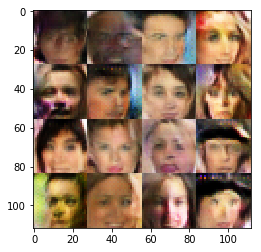

Epoch 2/2 - trainstep 4710:   DiscriminatorLoss: 1.3932   GeneratorLoss    : 0.7804
Epoch 2/2 - trainstep 4720:   DiscriminatorLoss: 1.4404   GeneratorLoss    : 0.6800
Epoch 2/2 - trainstep 4730:   DiscriminatorLoss: 1.2802   GeneratorLoss    : 0.7329
Epoch 2/2 - trainstep 4740:   DiscriminatorLoss: 1.4226   GeneratorLoss    : 0.7271
Epoch 2/2 - trainstep 4750:   DiscriminatorLoss: 1.3774   GeneratorLoss    : 0.6589
Epoch 2/2 - trainstep 4760:   DiscriminatorLoss: 1.4170   GeneratorLoss    : 0.7088
Epoch 2/2 - trainstep 4770:   DiscriminatorLoss: 1.2493   GeneratorLoss    : 0.8359
Epoch 2/2 - trainstep 4780:   DiscriminatorLoss: 1.4476   GeneratorLoss    : 0.7496
Epoch 2/2 - trainstep 4790:   DiscriminatorLoss: 1.2793   GeneratorLoss    : 0.8173
Epoch 2/2 - trainstep 4800:   DiscriminatorLoss: 1.3333   GeneratorLoss    : 0.7603


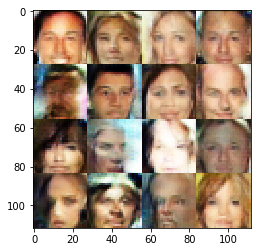

Epoch 2/2 - trainstep 4810:   DiscriminatorLoss: 1.4195   GeneratorLoss    : 0.7080
Epoch 2/2 - trainstep 4820:   DiscriminatorLoss: 1.3286   GeneratorLoss    : 0.6975
Epoch 2/2 - trainstep 4830:   DiscriminatorLoss: 1.4184   GeneratorLoss    : 0.6784
Epoch 2/2 - trainstep 4840:   DiscriminatorLoss: 1.3293   GeneratorLoss    : 0.8707
Epoch 2/2 - trainstep 4850:   DiscriminatorLoss: 1.3542   GeneratorLoss    : 0.8697
Epoch 2/2 - trainstep 4860:   DiscriminatorLoss: 1.4000   GeneratorLoss    : 0.7637
Epoch 2/2 - trainstep 4870:   DiscriminatorLoss: 1.4256   GeneratorLoss    : 0.7290
Epoch 2/2 - trainstep 4880:   DiscriminatorLoss: 1.3245   GeneratorLoss    : 0.7646
Epoch 2/2 - trainstep 4890:   DiscriminatorLoss: 1.4328   GeneratorLoss    : 0.7292
Epoch 2/2 - trainstep 4900:   DiscriminatorLoss: 1.3185   GeneratorLoss    : 0.7713


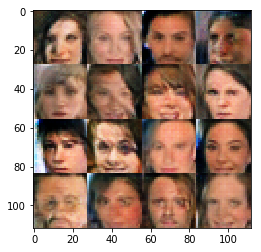

Epoch 2/2 - trainstep 4910:   DiscriminatorLoss: 1.3650   GeneratorLoss    : 0.8066
Epoch 2/2 - trainstep 4920:   DiscriminatorLoss: 1.3833   GeneratorLoss    : 0.7191
Epoch 2/2 - trainstep 4930:   DiscriminatorLoss: 1.3731   GeneratorLoss    : 0.7897
Epoch 2/2 - trainstep 4940:   DiscriminatorLoss: 1.3771   GeneratorLoss    : 0.7745
Epoch 2/2 - trainstep 4950:   DiscriminatorLoss: 1.3669   GeneratorLoss    : 0.7372
Epoch 2/2 - trainstep 4960:   DiscriminatorLoss: 1.3955   GeneratorLoss    : 0.7281
Epoch 2/2 - trainstep 4970:   DiscriminatorLoss: 1.3951   GeneratorLoss    : 0.7142
Epoch 2/2 - trainstep 4980:   DiscriminatorLoss: 1.3659   GeneratorLoss    : 0.7358
Epoch 2/2 - trainstep 4990:   DiscriminatorLoss: 1.3929   GeneratorLoss    : 0.7678
Epoch 2/2 - trainstep 5000:   DiscriminatorLoss: 1.3903   GeneratorLoss    : 0.7950


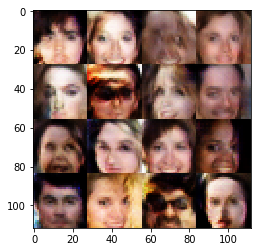

Epoch 2/2 - trainstep 5010:   DiscriminatorLoss: 1.4130   GeneratorLoss    : 0.7226
Epoch 2/2 - trainstep 5020:   DiscriminatorLoss: 1.3122   GeneratorLoss    : 0.7501
Epoch 2/2 - trainstep 5030:   DiscriminatorLoss: 1.3629   GeneratorLoss    : 0.7461
Epoch 2/2 - trainstep 5040:   DiscriminatorLoss: 1.4359   GeneratorLoss    : 0.7894
Epoch 2/2 - trainstep 5050:   DiscriminatorLoss: 1.4213   GeneratorLoss    : 0.6847
Epoch 2/2 - trainstep 5060:   DiscriminatorLoss: 1.3489   GeneratorLoss    : 0.7737
Epoch 2/2 - trainstep 5070:   DiscriminatorLoss: 1.3671   GeneratorLoss    : 0.8003
Epoch 2/2 - trainstep 5080:   DiscriminatorLoss: 1.3928   GeneratorLoss    : 0.6728
Epoch 2/2 - trainstep 5090:   DiscriminatorLoss: 1.3303   GeneratorLoss    : 0.7948
Epoch 2/2 - trainstep 5100:   DiscriminatorLoss: 1.3758   GeneratorLoss    : 0.7630


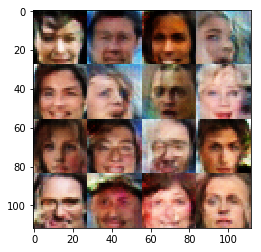

Epoch 2/2 - trainstep 5110:   DiscriminatorLoss: 1.4303   GeneratorLoss    : 0.6623
Epoch 2/2 - trainstep 5120:   DiscriminatorLoss: 1.5033   GeneratorLoss    : 0.7007
Epoch 2/2 - trainstep 5130:   DiscriminatorLoss: 1.3844   GeneratorLoss    : 0.7973
Epoch 2/2 - trainstep 5140:   DiscriminatorLoss: 1.4246   GeneratorLoss    : 0.7542
Epoch 2/2 - trainstep 5150:   DiscriminatorLoss: 1.3450   GeneratorLoss    : 0.7538
Epoch 2/2 - trainstep 5160:   DiscriminatorLoss: 1.4152   GeneratorLoss    : 0.7445
Epoch 2/2 - trainstep 5170:   DiscriminatorLoss: 1.3864   GeneratorLoss    : 0.7450
Epoch 2/2 - trainstep 5180:   DiscriminatorLoss: 1.3935   GeneratorLoss    : 0.7270
Epoch 2/2 - trainstep 5190:   DiscriminatorLoss: 1.3919   GeneratorLoss    : 0.7372
Epoch 2/2 - trainstep 5200:   DiscriminatorLoss: 1.4238   GeneratorLoss    : 0.7004


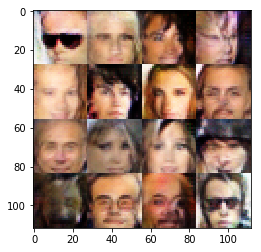

Epoch 2/2 - trainstep 5210:   DiscriminatorLoss: 1.3896   GeneratorLoss    : 0.7610
Epoch 2/2 - trainstep 5220:   DiscriminatorLoss: 1.3752   GeneratorLoss    : 0.7548
Epoch 2/2 - trainstep 5230:   DiscriminatorLoss: 1.2841   GeneratorLoss    : 0.7950
Epoch 2/2 - trainstep 5240:   DiscriminatorLoss: 1.4485   GeneratorLoss    : 0.6719
Epoch 2/2 - trainstep 5250:   DiscriminatorLoss: 1.3574   GeneratorLoss    : 0.7124
Epoch 2/2 - trainstep 5260:   DiscriminatorLoss: 1.4186   GeneratorLoss    : 0.7131
Epoch 2/2 - trainstep 5270:   DiscriminatorLoss: 1.3623   GeneratorLoss    : 0.8608
Epoch 2/2 - trainstep 5280:   DiscriminatorLoss: 1.3413   GeneratorLoss    : 0.7424
Epoch 2/2 - trainstep 5290:   DiscriminatorLoss: 1.3929   GeneratorLoss    : 0.7664
Epoch 2/2 - trainstep 5300:   DiscriminatorLoss: 1.3120   GeneratorLoss    : 0.6789


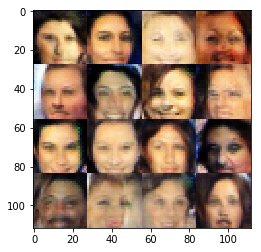

Epoch 2/2 - trainstep 5310:   DiscriminatorLoss: 1.3884   GeneratorLoss    : 0.7491
Epoch 2/2 - trainstep 5320:   DiscriminatorLoss: 1.3542   GeneratorLoss    : 0.7586
Epoch 2/2 - trainstep 5330:   DiscriminatorLoss: 1.3717   GeneratorLoss    : 0.7396
Epoch 2/2 - trainstep 5340:   DiscriminatorLoss: 1.3210   GeneratorLoss    : 0.7575
Epoch 2/2 - trainstep 5350:   DiscriminatorLoss: 1.3875   GeneratorLoss    : 0.6762
Epoch 2/2 - trainstep 5360:   DiscriminatorLoss: 1.4026   GeneratorLoss    : 0.7717
Epoch 2/2 - trainstep 5370:   DiscriminatorLoss: 1.3524   GeneratorLoss    : 0.7743
Epoch 2/2 - trainstep 5380:   DiscriminatorLoss: 1.3328   GeneratorLoss    : 0.7360
Epoch 2/2 - trainstep 5390:   DiscriminatorLoss: 1.4454   GeneratorLoss    : 0.7877
Epoch 2/2 - trainstep 5400:   DiscriminatorLoss: 1.4232   GeneratorLoss    : 0.6400


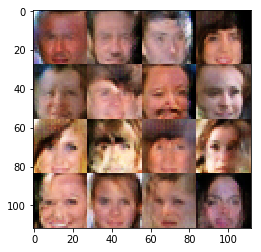

Epoch 2/2 - trainstep 5410:   DiscriminatorLoss: 1.3545   GeneratorLoss    : 0.7698
Epoch 2/2 - trainstep 5420:   DiscriminatorLoss: 1.4229   GeneratorLoss    : 0.6838
Epoch 2/2 - trainstep 5430:   DiscriminatorLoss: 1.3651   GeneratorLoss    : 0.7480
Epoch 2/2 - trainstep 5440:   DiscriminatorLoss: 1.3065   GeneratorLoss    : 0.8034
Epoch 2/2 - trainstep 5450:   DiscriminatorLoss: 1.4289   GeneratorLoss    : 0.7089
Epoch 2/2 - trainstep 5460:   DiscriminatorLoss: 1.3931   GeneratorLoss    : 0.6618
Epoch 2/2 - trainstep 5470:   DiscriminatorLoss: 1.4043   GeneratorLoss    : 0.6858
Epoch 2/2 - trainstep 5480:   DiscriminatorLoss: 1.3186   GeneratorLoss    : 0.7774
Epoch 2/2 - trainstep 5490:   DiscriminatorLoss: 1.3417   GeneratorLoss    : 0.7830
Epoch 2/2 - trainstep 5500:   DiscriminatorLoss: 1.4070   GeneratorLoss    : 0.6753


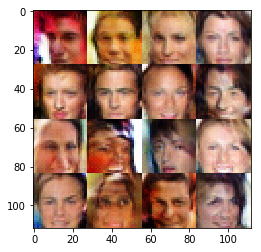

Epoch 2/2 - trainstep 5510:   DiscriminatorLoss: 1.3923   GeneratorLoss    : 0.7824
Epoch 2/2 - trainstep 5520:   DiscriminatorLoss: 1.3585   GeneratorLoss    : 0.6950
Epoch 2/2 - trainstep 5530:   DiscriminatorLoss: 1.3503   GeneratorLoss    : 0.7338
Epoch 2/2 - trainstep 5540:   DiscriminatorLoss: 1.3653   GeneratorLoss    : 0.7626
Epoch 2/2 - trainstep 5550:   DiscriminatorLoss: 1.3443   GeneratorLoss    : 0.7372
Epoch 2/2 - trainstep 5560:   DiscriminatorLoss: 1.3357   GeneratorLoss    : 0.7760
Epoch 2/2 - trainstep 5570:   DiscriminatorLoss: 1.3360   GeneratorLoss    : 0.7533
Epoch 2/2 - trainstep 5580:   DiscriminatorLoss: 1.4157   GeneratorLoss    : 0.7844
Epoch 2/2 - trainstep 5590:   DiscriminatorLoss: 1.3042   GeneratorLoss    : 0.8594
Epoch 2/2 - trainstep 5600:   DiscriminatorLoss: 1.3913   GeneratorLoss    : 0.6752


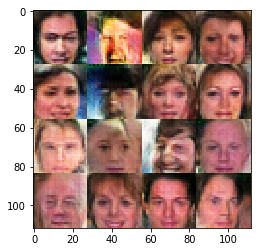

Epoch 2/2 - trainstep 5610:   DiscriminatorLoss: 1.4417   GeneratorLoss    : 0.6726
Epoch 2/2 - trainstep 5620:   DiscriminatorLoss: 1.3767   GeneratorLoss    : 0.7322
Epoch 2/2 - trainstep 5630:   DiscriminatorLoss: 1.4027   GeneratorLoss    : 0.6963
Epoch 2/2 - trainstep 5640:   DiscriminatorLoss: 1.4949   GeneratorLoss    : 0.5977
Epoch 2/2 - trainstep 5650:   DiscriminatorLoss: 1.4179   GeneratorLoss    : 0.7360
Epoch 2/2 - trainstep 5660:   DiscriminatorLoss: 1.3900   GeneratorLoss    : 0.7160
Epoch 2/2 - trainstep 5670:   DiscriminatorLoss: 1.3563   GeneratorLoss    : 0.7956
Epoch 2/2 - trainstep 5680:   DiscriminatorLoss: 1.3635   GeneratorLoss    : 0.6616
Epoch 2/2 - trainstep 5690:   DiscriminatorLoss: 1.3752   GeneratorLoss    : 0.7875
Epoch 2/2 - trainstep 5700:   DiscriminatorLoss: 1.2995   GeneratorLoss    : 0.7858


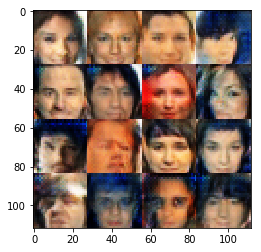

Epoch 2/2 - trainstep 5710:   DiscriminatorLoss: 1.4374   GeneratorLoss    : 0.7852
Epoch 2/2 - trainstep 5720:   DiscriminatorLoss: 1.3890   GeneratorLoss    : 0.7715
Epoch 2/2 - trainstep 5730:   DiscriminatorLoss: 1.2943   GeneratorLoss    : 0.7978
Epoch 2/2 - trainstep 5740:   DiscriminatorLoss: 1.3406   GeneratorLoss    : 0.7553
Epoch 2/2 - trainstep 5750:   DiscriminatorLoss: 1.4119   GeneratorLoss    : 0.6866
Epoch 2/2 - trainstep 5760:   DiscriminatorLoss: 1.3777   GeneratorLoss    : 0.7081
Epoch 2/2 - trainstep 5770:   DiscriminatorLoss: 1.4479   GeneratorLoss    : 0.7091
Epoch 2/2 - trainstep 5780:   DiscriminatorLoss: 1.2994   GeneratorLoss    : 0.7330
Epoch 2/2 - trainstep 5790:   DiscriminatorLoss: 1.4730   GeneratorLoss    : 0.6299
Epoch 2/2 - trainstep 5800:   DiscriminatorLoss: 1.3554   GeneratorLoss    : 0.7540


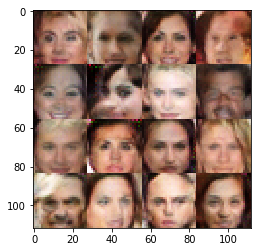

Epoch 2/2 - trainstep 5810:   DiscriminatorLoss: 1.4032   GeneratorLoss    : 0.7249
Epoch 2/2 - trainstep 5820:   DiscriminatorLoss: 1.3715   GeneratorLoss    : 0.7151
Epoch 2/2 - trainstep 5830:   DiscriminatorLoss: 1.3916   GeneratorLoss    : 0.7219
Epoch 2/2 - trainstep 5840:   DiscriminatorLoss: 1.5307   GeneratorLoss    : 0.6422
Epoch 2/2 - trainstep 5850:   DiscriminatorLoss: 1.3833   GeneratorLoss    : 0.7165
Epoch 2/2 - trainstep 5860:   DiscriminatorLoss: 1.4711   GeneratorLoss    : 0.7667
Epoch 2/2 - trainstep 5870:   DiscriminatorLoss: 1.3477   GeneratorLoss    : 0.8520
Epoch 2/2 - trainstep 5880:   DiscriminatorLoss: 1.3686   GeneratorLoss    : 0.7876
Epoch 2/2 - trainstep 5890:   DiscriminatorLoss: 1.3043   GeneratorLoss    : 0.7794
Epoch 2/2 - trainstep 5900:   DiscriminatorLoss: 1.3748   GeneratorLoss    : 0.7026


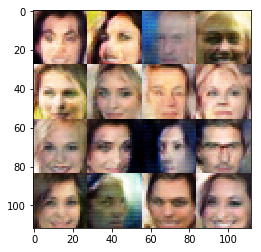

Epoch 2/2 - trainstep 5910:   DiscriminatorLoss: 1.3731   GeneratorLoss    : 0.6903
Epoch 2/2 - trainstep 5920:   DiscriminatorLoss: 1.4090   GeneratorLoss    : 0.7208
Epoch 2/2 - trainstep 5930:   DiscriminatorLoss: 1.3233   GeneratorLoss    : 0.8040
Epoch 2/2 - trainstep 5940:   DiscriminatorLoss: 1.3423   GeneratorLoss    : 0.7829
Epoch 2/2 - trainstep 5950:   DiscriminatorLoss: 1.4414   GeneratorLoss    : 0.6880
Epoch 2/2 - trainstep 5960:   DiscriminatorLoss: 1.3944   GeneratorLoss    : 0.6885
Epoch 2/2 - trainstep 5970:   DiscriminatorLoss: 1.3569   GeneratorLoss    : 0.7999
Epoch 2/2 - trainstep 5980:   DiscriminatorLoss: 1.3860   GeneratorLoss    : 0.7399
Epoch 2/2 - trainstep 5990:   DiscriminatorLoss: 1.3720   GeneratorLoss    : 0.7364
Epoch 2/2 - trainstep 6000:   DiscriminatorLoss: 1.3517   GeneratorLoss    : 0.7406


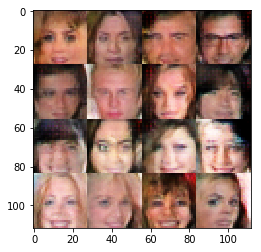

Epoch 2/2 - trainstep 6010:   DiscriminatorLoss: 1.3497   GeneratorLoss    : 0.7779
Epoch 2/2 - trainstep 6020:   DiscriminatorLoss: 1.3509   GeneratorLoss    : 0.7092
Epoch 2/2 - trainstep 6030:   DiscriminatorLoss: 1.3223   GeneratorLoss    : 0.7246
Epoch 2/2 - trainstep 6040:   DiscriminatorLoss: 1.3445   GeneratorLoss    : 0.7405
Epoch 2/2 - trainstep 6050:   DiscriminatorLoss: 1.4367   GeneratorLoss    : 0.7299
Epoch 2/2 - trainstep 6060:   DiscriminatorLoss: 1.4004   GeneratorLoss    : 0.7466
Epoch 2/2 - trainstep 6070:   DiscriminatorLoss: 1.4057   GeneratorLoss    : 0.7172
Epoch 2/2 - trainstep 6080:   DiscriminatorLoss: 1.4364   GeneratorLoss    : 0.7098
Epoch 2/2 - trainstep 6090:   DiscriminatorLoss: 1.3970   GeneratorLoss    : 0.6877
Epoch 2/2 - trainstep 6100:   DiscriminatorLoss: 1.3538   GeneratorLoss    : 0.7031


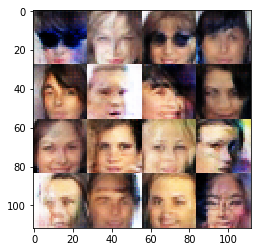

Epoch 2/2 - trainstep 6110:   DiscriminatorLoss: 1.4407   GeneratorLoss    : 0.7706
Epoch 2/2 - trainstep 6120:   DiscriminatorLoss: 1.3554   GeneratorLoss    : 0.7408
Epoch 2/2 - trainstep 6130:   DiscriminatorLoss: 1.3230   GeneratorLoss    : 0.7129
Epoch 2/2 - trainstep 6140:   DiscriminatorLoss: 1.4047   GeneratorLoss    : 0.6373
Epoch 2/2 - trainstep 6150:   DiscriminatorLoss: 1.3577   GeneratorLoss    : 0.8095
Epoch 2/2 - trainstep 6160:   DiscriminatorLoss: 1.3904   GeneratorLoss    : 0.7551
Epoch 2/2 - trainstep 6170:   DiscriminatorLoss: 1.3581   GeneratorLoss    : 0.7466
Epoch 2/2 - trainstep 6180:   DiscriminatorLoss: 1.4036   GeneratorLoss    : 0.7710
Epoch 2/2 - trainstep 6190:   DiscriminatorLoss: 1.3456   GeneratorLoss    : 0.7488
Epoch 2/2 - trainstep 6200:   DiscriminatorLoss: 1.3337   GeneratorLoss    : 0.7934


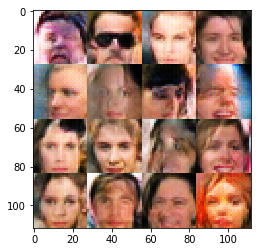

Epoch 2/2 - trainstep 6210:   DiscriminatorLoss: 1.3325   GeneratorLoss    : 0.7758
Epoch 2/2 - trainstep 6220:   DiscriminatorLoss: 1.4297   GeneratorLoss    : 0.7449
Epoch 2/2 - trainstep 6230:   DiscriminatorLoss: 1.4020   GeneratorLoss    : 0.7858
Epoch 2/2 - trainstep 6240:   DiscriminatorLoss: 1.3970   GeneratorLoss    : 0.6080
Epoch 2/2 - trainstep 6250:   DiscriminatorLoss: 1.3980   GeneratorLoss    : 0.7231
Epoch 2/2 - trainstep 6260:   DiscriminatorLoss: 1.2964   GeneratorLoss    : 0.7881
Epoch 2/2 - trainstep 6270:   DiscriminatorLoss: 1.3805   GeneratorLoss    : 0.7769
Epoch 2/2 - trainstep 6280:   DiscriminatorLoss: 1.3455   GeneratorLoss    : 0.7603
Epoch 2/2 - trainstep 6290:   DiscriminatorLoss: 1.3709   GeneratorLoss    : 0.6927
Epoch 2/2 - trainstep 6300:   DiscriminatorLoss: 1.3637   GeneratorLoss    : 0.7409


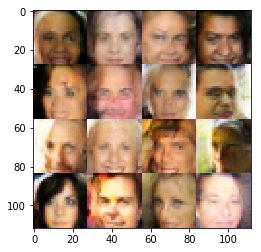

Epoch 2/2 - trainstep 6310:   DiscriminatorLoss: 1.3878   GeneratorLoss    : 0.7435
Epoch 2/2 - trainstep 6320:   DiscriminatorLoss: 1.3224   GeneratorLoss    : 0.8280
Epoch 2/2 - trainstep 6330:   DiscriminatorLoss: 1.3770   GeneratorLoss    : 0.7471


In [13]:
batch_size = 64
z_dim = 128
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.